In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

## IMPORTS

In [2]:
from copy import deepcopy, copy
from hdbscan import all_points_membership_vectors, HDBSCAN
# from matplotlib.axes import Axes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
# from typing import Dict, List, Tuple, Optional
from umap import UMAP
# from upsetplot import from_memberships, plot, UpSet, from_indicators, from_contents
import colorcet as cc
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors

# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy

from project_modules.clustering import make_feature_importance_df, make_topN_features, make_plot_df

from project_modules.clustering import plot_feature_importances, plot_clusters, plot_multiple_features

# colour palette work
palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

# make a matplotlib cmap from limegreen to white
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("limegreen-white", 
                                         ["white", "limegreen"])



FONTSIZE = 24

In [3]:
# set the default font for all matplotlib plots
plt.rcParams['font.family'] = 'Aptos'

In [4]:
# parameters and dicts

# heatmap parameters
heatmap_parms = {
                'cbar': False,
                'square': False,
                'linewidths': 0.5,
                'linecolor': 'black',
                'center': 0.0,
                'vmin': -1,
                'vmax': 1,
                # 'annot': False,
                'fmt': '.2f',
}

# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}
# from the data dictionary
site_fullname_dict = {
                  'LDN': "London",
                  'MTL': "Montreal",
                  'SAN': "San Diego",
                  'RIO': "Rio de Janeiro",
                  'LUS': "Lusaka",
}
# from the data dictionary
site_fullname_int_dict = {
                  1: "London",
                  2: "Montreal",
                  3: "San Diego",
                  4: "Rio de Janeiro",
                  5: "Lusaka",
}

# assign consistent styles
site_style_dict = {
              1: 'o',
              2: 'D',
              3: 'P',
              4: 'X',
              5: 's',
}

In [5]:
# input and output paths

figdir    = "./OUTPUT/lc-pos-figures"
reportdir = "../lc2-report"
data_dir  = "../lc-project-data"

In [6]:
# timestamp for saving figures

import datetime as dt

timestamp = dt.datetime.now().strftime("%Y-%m-%d")
print(f"The timestamp is {timestamp}")

# check to see if there is a subdirectory in figdir for the timestamp
import os

if not os.path.exists(os.path.join(figdir, timestamp)):
    os.makedirs(os.path.join(figdir, timestamp))

# redirect output to figdir/timestamp

figdir = os.path.join(figdir, timestamp)

print(figdir)

The timestamp is 2025-02-02
./OUTPUT/lc-pos-figures/2025-02-02


## FUNCTIONS

In [7]:
#===============================================================================
def compare_two_clusters(df, a, b):
#===============================================================================
# a function to compare two clusters - returns the concatenated cluster data for further analysis

    subset_a = df.query(f"cluster == {a}")
    subset_b = df.query(f"cluster == {b}")

    index_a = subset_a.index
    index_b = subset_b.index

    df_a = df.loc[index_a]
    df_b = df.loc[index_b]

    # concatenate
    df_ab = pd.concat([df_a, df_b])

    # cast cluster to int
    df_ab["cluster"] = df_ab["cluster"].astype(int)

    return df_ab


In [8]:
#===============================================================================
def make_upset_data(df, 
                    ftrs, 
                    method = "mean", 
                    add_column = None,
                    keep_features = False):
#===============================================================================

    if method not in ["mean", "median"]:
        print(f"Method {method} not supported.")

    else:
        if method == "mean":
            new_df = df[ftrs] > df[ftrs].mean(axis = 0)
        # elif method == "median":
        else:
            new_df = df[ftrs] > df[ftrs].median(axis = 0)

    new_df = new_df[ftrs]
    new_df.rename(columns= {c: f">{c}" for c in ftrs}, inplace = True)

    df2 = pd.concat([df, new_df, add_column], axis = 1) # type: ignore
    # if keep_features == True:
    #     pass
    # else:
    #     df2 = df2.set_index(list(new_df.columns))

    return df2

In [9]:
#===============================================================================
def excursion_plot(d, 
                    method = "mean",
                    grouper = "cluster",
                    style: str = "binary",
                    # figsize = (6,64),
                    ax = None,
                    cmap = cc.cm.bjy,
                    top_n = None,
                    ):
#===============================================================================

    # TODO: colour map to match the cluster thumbnails
    # TODO: drop age, sex

    norm = None

    # qq.astype(int)
    if ax == None:
        fig, ax = plt.subplots()
    else:
        ax = ax


    # find all object columns and drop them
    d = d.select_dtypes(exclude = "object")

    # set the figsize to scale with the number of features
    figsize = (6, d.shape[1] / 5)

    # get the global median for each feature
    global_median = d.median()
    global_mean   = d.mean()

    globals = pd.concat([global_median, global_mean], axis = 1)
    globals.columns = ["Ensemble Median", "Ensemble Mean"]

    globals.drop(grouper, inplace = True)


    # per feature mean and median
    mm_mean   = d.groupby(grouper).mean().T
    mm_median = d.groupby(grouper).median().T

    # which version?
    if method == "mean":
        mm = mm_mean
        selector = "Ensemble Mean"
    elif method == "median":
        mm = mm_median
        selector = "Ensemble Median"
    else:
        print(f"Method {method} not supported.")
        

    if top_n is not None:
        mm = mm[:top_n]

    if style == "cont":
        # do the basic plot of means or medians
        # colourmap
        # cmap = cc.cm.bjy
        # fig, ax = plt.subplots(figsize=figsize)

        # heatmsp
        sns.heatmap(mm, 
                        cmap = cmap, 
                        ax   = ax, 
                        **heatmap_parms, 
                        norm = norm, 
                        annot = True,
                        annot_kws = {"fontsize": 8}
                        )

        plt.title(f"Excursion Plot: Feature {str.title(method)} by Cluster")
        plt.yticks(fontsize = 8);
        qq = None

    else:
        # mm is the mean or median per cluster per feature
        qq = pd.DataFrame(index = mm.index, columns = mm.columns)

        # for each cluster c in mm, 
        for c in mm.columns:
            # for each feature in this cluster, compare to the respective global mean
            for i, v in enumerate(mm[c].values):
                # is this cluster's mean or median greater than 
                # the global ensemble mean or median?
                # this will fill qq with true/false
                qq.loc[qq.index[i],c] = v >  globals.loc[qq.index[i], selector] # type: ignore

        # # qq.astype(int)
        # fig, ax = plt.subplots(figsize=figsize)

        sns.heatmap(qq.astype(int), 
                    # cmap = cc.bjy, 
                    cmap = cmap,
                    ax = ax, 
                    cbar = False, 
                    vmin = 0, 
                    linewidth = 0.5, 
                    square = False, 
                    linecolor = 'k'
                    )

        plt.yticks(fontsize = 8);
        plt.title(f"Excursion Plot: {str.title(grouper)} {str.title(method)} > {selector}")

    return globals, qq

## LOAD DATA

In [10]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset

# get today's date

import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

# load the dataset from disk
today = "2024-08-23"
ds     = Dataset.load_from_disk(f'../lc-project-data/RECAP-TEST-{today}-features.arrow')

today = "2024-05-05"
ds_all = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')
ds     = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')

In [11]:
# df_all = ds_all.data.to_pandas()
df     = ds.data.to_pandas()

In [12]:
# drop __index_level_0__
try:
    df = df.drop(columns = ["__index_level_0__"])
except KeyError:
    pass

In [13]:
df

sex   age  SITE  MED-Analgesics  MED-Anesthetics  MED-Antibacterials  \
0     2.0  30.0     2               0                0                   0   
1     1.0  33.0     2               0                0                   0   
2     2.0  36.0     2               0                0                   0   
3     2.0  50.0     2               0                0                   0   
4     1.0  40.0     2               0                0                   0   
...   ...   ...   ...             ...              ...                 ...   
5659  1.0  48.0     3               0                0                   0   
5660  2.0  42.0     3               0                0                   0   
5661  1.0  23.0     3               0                0                   0   
5662  1.0  71.0     3               0                0                   0   
5663  2.0  58.0     3               0                0                   0   

      MED-Anticonvulsants  MED-Antidepressants  MED-Antifungals  \
0                       0                    0                0   
1                       0                    0                0   
2                       0                    0                0   
3                       0                    0                0   
4                       0                    0                0   
...                   ...                  ...              ...   
5659                    0                    0                0   
5660                    0                    0                0   
5661                    0                    0                0   
5662                    0                    0                0   
5663                    0                    0                0   

      MED-Antimigraine-agents  ...  LABS-IND-troponint  \
0                           0  ...                 0.0   
1                           0  ...                 0.0   
2                           0  ...                 0.0   
3                           0  ...                 0.0   
4                           0  ...                 0.0   
...                       ...  ...                 ...   
5659                        0  ...                 0.0   
5660                        0  ...                 0.0   
5661                        0  ...                 0.0   
5662                        0  ...                 0.0   
5663                        0  ...                 0.0   

      LABS-IND-troponinthigh  LABS-IND-urea  LABS-IND-wbc  SUBST-1  SUBST-2  \
0                        0.0            0.0           0.0      0.0      0.0   
1                        0.0            0.0           0.0      0.0      0.0   
2                        0.0            0.0           0.0      0.0      0.0   
3                        0.0            0.0           0.0      1.0      0.0   
4                        0.0            0.0           0.0      0.0      0.0   
...                      ...            ...           ...      ...      ...   
5659                     0.0            1.0           0.0      0.0      0.0   
5660                     0.0            1.0           1.0      0.0      0.0   
5661                     0.0            0.0           0.0      0.0      0.0   
5662                     0.0            1.0           0.0      0.0      0.0   
5663                     0.0            1.0           1.0      0.0      0.0   

      SUBST-3  SUBST-4  SUBST-5  LC_STATUS  
0         0.0      0.0      0.0     LC_POS  
1         0.0      0.0      0.0     LC_POS  
2         0.0      0.0      0.0     LC_POS  
3         0.0      0.0      0.0     LC_POS  
4         0.0      0.0      0.0     LC_POS  
...       ...      ...      ...        ...  
5659      1.0      0.0      0.0     LC_POS  
5660      0.0      0.0      0.0     LC_POS  
5661      1.0      1.0      0.0     LC_POS  
5662      0.0      0.0      0.0     LC_POS  
5663      0.0      0.0      0.0     LC_POS  

[5664 rows x 448 columns]

In [14]:
# # find all LC_STATUS that are HC
# hc = df.query("LC_STATUS == 'HC'")
# hc

### Feature names and colours

In [15]:
# import good feature names
feature_map_df = pd.read_csv(f"./JSON/niceFeatures.csv")

# construct a dict with feature as key and clean as value
feature_map = {row["feature"]: row["clean"] for i, row in feature_map_df.iterrows()}

# load the colourmap dict
import json

with open("./JSON/selectFeaturePalette_NiceFeat.json", "r") as f:
    feature_colour_map = json.load(f)

print(f"{len(feature_map)} features loaded.")
print(f"{len(feature_colour_map)} colours loaded.")

116 features loaded.
91 colours loaded.


## LC+, LC-, HC

### Select which sets of features to use

In [16]:
LC_pos = df.query('LC_STATUS == "LC_POS"').copy() # type: ignore
LC_neg = df.query('LC_STATUS == "LC_NEG"').copy() # type: ignore 
HC     = df.query('LC_STATUS == "HC"').copy()     # type: ignore


In [17]:
LC_pos.shape, LC_neg.shape, HC.shape

((2194, 448), (3367, 448), (103, 448))

In [18]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except:
    pass
LC_pos

sex   age  SITE  MED-Analgesics  MED-Anesthetics  MED-Antibacterials  \
0     2.0  30.0     2               0                0                   0   
1     1.0  33.0     2               0                0                   0   
2     2.0  36.0     2               0                0                   0   
3     2.0  50.0     2               0                0                   0   
4     1.0  40.0     2               0                0                   0   
...   ...   ...   ...             ...              ...                 ...   
5659  1.0  48.0     3               0                0                   0   
5660  2.0  42.0     3               0                0                   0   
5661  1.0  23.0     3               0                0                   0   
5662  1.0  71.0     3               0                0                   0   
5663  2.0  58.0     3               0                0                   0   

      MED-Anticonvulsants  MED-Antidepressants  MED-Antifungals  \
0                       0                    0                0   
1                       0                    0                0   
2                       0                    0                0   
3                       0                    0                0   
4                       0                    0                0   
...                   ...                  ...              ...   
5659                    0                    0                0   
5660                    0                    0                0   
5661                    0                    0                0   
5662                    0                    0                0   
5663                    0                    0                0   

      MED-Antimigraine-agents  ...  LABS-IND-troponinihigh  \
0                           0  ...                     0.0   
1                           0  ...                     0.0   
2                           0  ...                     0.0   
3                           0  ...                     0.0   
4                           0  ...                     0.0   
...                       ...  ...                     ...   
5659                        0  ...                     0.0   
5660                        0  ...                     0.0   
5661                        0  ...                     0.0   
5662                        0  ...                     0.0   
5663                        0  ...                     0.0   

      LABS-IND-troponint  LABS-IND-troponinthigh  LABS-IND-urea  LABS-IND-wbc  \
0                    0.0                     0.0            0.0           0.0   
1                    0.0                     0.0            0.0           0.0   
2                    0.0                     0.0            0.0           0.0   
3                    0.0                     0.0            0.0           0.0   
4                    0.0                     0.0            0.0           0.0   
...                  ...                     ...            ...           ...   
5659                 0.0                     0.0            1.0           0.0   
5660                 0.0                     0.0            1.0           1.0   
5661                 0.0                     0.0            0.0           0.0   
5662                 0.0                     0.0            1.0           0.0   
5663                 0.0                     0.0            1.0           1.0   

      SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5  
0         0.0      0.0      0.0      0.0      0.0  
1         0.0      0.0      0.0      0.0      0.0  
2         0.0      0.0      0.0      0.0      0.0  
3         1.0      0.0      0.0      0.0      0.0  
4         0.0      0.0      0.0      0.0      0.0  
...       ...      ...      ...      ...      ...  
5659      0.0      0.0      1.0      0.0      0.0  
5660      0.0      0.0      0.0      0.0      0.0  
5661      0.0      0.0      1.0      1.0      0.0  
5662      0.0      0.0    

In [19]:
# make a list of the columns
ftrs = list(df.columns)

# how many features start with one of ["SYMP", "CD", "MED"]?

for sw in ["SYMP", "CD", "MED", "VAX", "HHX", "IMG","LAB", "SUBS"]:
    print(sw, len([f for f in ftrs if f.startswith(sw)]))

SYMP 56
CD 244
MED 28
VAX 1
HHX 54
IMG 9
LAB 47
SUBS 5


# CLUSTERING

In [20]:
# clustering

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [21]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos.copy()

# drop certain columns, to experiment with effect on clustering

# drop columns that relate to non-covid events
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___4').columns)
# the foregoing drops medication_received___3 and medication_received___4
# we need to restore them
LC_pos_["CD-medication_received___3"] = df["CD-medication_received___3"]
LC_pos_["CD-medication_received___4"] = df["CD-medication_received___4"]
LC_pos_["CD-ventilatory_support_type___3"] = df["CD-ventilatory_support_type___3"]
LC_pos_["CD-ventilatory_support_type___4"] = df["CD-ventilatory_support_type___4"]

LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-4').columns)

# drop specific columns
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-severity_level').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-mode_of').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-type_of').columns)

# drop medications and substances
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED-').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SUBST-').columns)

# find all column names that start with SYMPT and end with ___1
# these are for the initial covid infection
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SYMPT.*___1').columns)

# drop all HHX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'HHX').columns)

# drop all VAX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'VAX').columns)

# drop all CD-covid_test_result
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-covid_test_result').columns)

# drop all LABS-IND*
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS-IND').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'IMG').columns)

# drop all CD-
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-').columns)

vitals = ['temperature',
'heart_rate',
'bp_systolic',
'bp_diastolic',
'respiratory_rate',
'o2_saturation',]

# remove any features that contain words inthe vitals list
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '|'.join(vitals)).columns)


print(LC_pos_.shape)
# for c in LC_pos_.columns:
#     print(c)
# sort the feature names alphabetically
LC_pos_ = LC_pos_.sort_index(axis = 1)
print(LC_pos_.shape)

(2194, 246)
(2194, 246)


In [22]:
# get a list of all features that start with CD- and end with ___1
# these are the initial covid symptoms
new_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___1")]

new_symptoms = []

# get a list of all features that start with CD- and end with ___2
# these are the follow-up covid symptoms
worse_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___2")]

lc_symptoms = [f for f in LC_pos_.columns if f.startswith("SYMPT-") and f.endswith("___2")]

new_and_worse = new_symptoms + worse_symptoms + lc_symptoms
new_and_worse = lc_symptoms

In [23]:
# sort new_and_worse
new_and_worse = sorted(new_and_worse)

In [24]:
LC_pos_

CD-acute_kidney_injury___1  CD-acute_kidney_injury___2  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
...                          ...                         ...   
5659                         0.0                         0.0   
5660                         0.0                         0.0   
5661                         0.0                         0.0   
5662                         0.0                         0.0   
5663                         0.0                         0.0   

      CD-acute_respiratory_distress___1  CD-acute_respiratory_distress___2  \
0                                   0.0                                0.0   
1                                   0.0                                0.0   
2                                   0.0                                0.0   
3                                   0.0                                0.0   
4                                   0.0                                0.0   
...                                 ...                                ...   
5659                                0.0                                0.0   
5660                                0.0                                0.0   
5661                                0.0                                0.0   
5662                                0.0                                0.0   
5663                                0.0                                0.0   

      CD-adjunctive___1  CD-anemia___1  CD-anemia___2  CD-anxiety___1  \
0                   0.0            0.0            0.0             0.0   
1                   0.0            0.0            0.0             0.0   
2                   0.0            0.0            0.0             0.0   
3                   0.0            0.0            0.0             0.0   
4                   0.0            0.0            0.0             0.0   
...                 ...            ...            ...             ...   
5659                0.0            0.0            0.0             0.0   
5660                0.0            0.0            0.0             0.0   
5661                0.0            0.0            0.0             0.0   
5662                0.0            0.0            0.0             0.0   
5663                0.0            0.0            0.0             0.0   

      CD-anxiety___2  CD-asthma___1  ...  SYMPT-seizure___2  \
0                0.0            0.0  ...                0.0   
1                0.0            0.0  ...                0.0   
2                0.0            0.0  ...                0.0   
3                0.0            0.0  ...                0.0   
4                0.0            0.0  ...                0.0   
...              ...            ...  ...                ...   
5659             0.0            0.0  ...                0.0   
5660             0.0            0.0  ...                0.0   
5661             0.0            0.0  ...                0.0   
5662             0.0            0.0  ...                0.0   
5663             0.0            0.0  ...                0.0   

      SYMPT-shortness_of_breath_dyspne___2  SYMPT-skin_rash___2  \
0                                      0.0                  0.0   
1                                      1.0                  0.0   
2                                      0.0                  0.0   
3                                      1.0                  0.0   
4                                      0.0                  0.0   
...                                    ...                  ...   
5659                                   1.0                  0.0   
5660                                   0.0                  0.0   
5661                                   1.0                  0.0

In [25]:
# add site back to LC_pos_
# LC_pos_["site"] = df["SITE"]


In [26]:
# drop SITE columns - these might guide the clustering algorithm to cluster by site

try:
    LC_pos_ = LC_pos_.drop(columns=['LC_STATUS'])
except:
    pass

# always drop the SITE!
# X = scaler.fit_transform(LC_pos_.drop(columns=['SITE']))     # type: ignore
X = scaler.fit_transform(LC_pos_)     # type: ignore


# sort X randomly
# X = X.sample(frac = 1)

In [27]:
# is SITE in LC_pos_.columns?
"SITE" in LC_pos_.columns


True

In [28]:
LC_pos_

CD-acute_kidney_injury___1  CD-acute_kidney_injury___2  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
...                          ...                         ...   
5659                         0.0                         0.0   
5660                         0.0                         0.0   
5661                         0.0                         0.0   
5662                         0.0                         0.0   
5663                         0.0                         0.0   

      CD-acute_respiratory_distress___1  CD-acute_respiratory_distress___2  \
0                                   0.0                                0.0   
1                                   0.0                                0.0   
2                                   0.0                                0.0   
3                                   0.0                                0.0   
4                                   0.0                                0.0   
...                                 ...                                ...   
5659                                0.0                                0.0   
5660                                0.0                                0.0   
5661                                0.0                                0.0   
5662                                0.0                                0.0   
5663                                0.0                                0.0   

      CD-adjunctive___1  CD-anemia___1  CD-anemia___2  CD-anxiety___1  \
0                   0.0            0.0            0.0             0.0   
1                   0.0            0.0            0.0             0.0   
2                   0.0            0.0            0.0             0.0   
3                   0.0            0.0            0.0             0.0   
4                   0.0            0.0            0.0             0.0   
...                 ...            ...            ...             ...   
5659                0.0            0.0            0.0             0.0   
5660                0.0            0.0            0.0             0.0   
5661                0.0            0.0            0.0             0.0   
5662                0.0            0.0            0.0             0.0   
5663                0.0            0.0            0.0             0.0   

      CD-anxiety___2  CD-asthma___1  ...  SYMPT-seizure___2  \
0                0.0            0.0  ...                0.0   
1                0.0            0.0  ...                0.0   
2                0.0            0.0  ...                0.0   
3                0.0            0.0  ...                0.0   
4                0.0            0.0  ...                0.0   
...              ...            ...  ...                ...   
5659             0.0            0.0  ...                0.0   
5660             0.0            0.0  ...                0.0   
5661             0.0            0.0  ...                0.0   
5662             0.0            0.0  ...                0.0   
5663             0.0            0.0  ...                0.0   

      SYMPT-shortness_of_breath_dyspne___2  SYMPT-skin_rash___2  \
0                                      0.0                  0.0   
1                                      1.0                  0.0   
2                                      0.0                  0.0   
3                                      1.0                  0.0   
4                                      0.0                  0.0   
...                                    ...                  ...   
5659                                   1.0                  0.0   
5660                                   0.0                  0.0   
5661                                   1.0                  0.0

In [29]:
X

CD-acute_kidney_injury___1  CD-acute_kidney_injury___2  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
...                          ...                         ...   
5659                         0.0                         0.0   
5660                         0.0                         0.0   
5661                         0.0                         0.0   
5662                         0.0                         0.0   
5663                         0.0                         0.0   

      CD-acute_respiratory_distress___1  CD-acute_respiratory_distress___2  \
0                                   0.0                                0.0   
1                                   0.0                                0.0   
2                                   0.0                                0.0   
3                                   0.0                                0.0   
4                                   0.0                                0.0   
...                                 ...                                ...   
5659                                0.0                                0.0   
5660                                0.0                                0.0   
5661                                0.0                                0.0   
5662                                0.0                                0.0   
5663                                0.0                                0.0   

      CD-adjunctive___1  CD-anemia___1  CD-anemia___2  CD-anxiety___1  \
0                   0.0            0.0            0.0             0.0   
1                   0.0            0.0            0.0             0.0   
2                   0.0            0.0            0.0             0.0   
3                   0.0            0.0            0.0             0.0   
4                   0.0            0.0            0.0             0.0   
...                 ...            ...            ...             ...   
5659                0.0            0.0            0.0             0.0   
5660                0.0            0.0            0.0             0.0   
5661                0.0            0.0            0.0             0.0   
5662                0.0            0.0            0.0             0.0   
5663                0.0            0.0            0.0             0.0   

      CD-anxiety___2  CD-asthma___1  ...  SYMPT-seizure___2  \
0                0.0            0.0  ...                0.0   
1                0.0            0.0  ...                0.0   
2                0.0            0.0  ...                0.0   
3                0.0            0.0  ...                0.0   
4                0.0            0.0  ...                0.0   
...              ...            ...  ...                ...   
5659             0.0            0.0  ...                0.0   
5660             0.0            0.0  ...                0.0   
5661             0.0            0.0  ...                0.0   
5662             0.0            0.0  ...                0.0   
5663             0.0            0.0  ...                0.0   

      SYMPT-shortness_of_breath_dyspne___2  SYMPT-skin_rash___2  \
0                                      0.0                  0.0   
1                                      1.0                  0.0   
2                                      0.0                  0.0   
3                                      1.0                  0.0   
4                                      0.0                  0.0   
...                                    ...                  ...   
5659                                   1.0                  0.0   
5660                                   0.0                  0.0   
5661                                   1.0                  0.0

In [30]:
# list the columns in X

the_cols = X.columns
the_cols

Index(['CD-acute_kidney_injury___1', 'CD-acute_kidney_injury___2',
       'CD-acute_respiratory_distress___1',
       'CD-acute_respiratory_distress___2', 'CD-adjunctive___1',
       'CD-anemia___1', 'CD-anemia___2', 'CD-anxiety___1', 'CD-anxiety___2',
       'CD-asthma___1',
       ...
       'SYMPT-seizure___2', 'SYMPT-shortness_of_breath_dyspne___2',
       'SYMPT-skin_rash___2', 'SYMPT-sore_throat___2',
       'SYMPT-trouble_speaking_aphasia_d___2', 'SYMPT-weight_loss___2',
       'SYMPT-wheezing_or_stridor___2', 'VAX-vaccinated', 'age', 'sex'],
      dtype='object', length=246)

In [31]:
# save the list of columns to a file
with open("/Users/david/projects/lc2-proteomics-data/columns.txt", "w") as f:
    for c in the_cols:
        f.write(f"{c}\n")

## Use UMAP to visualize the data and cluster

### Handling missing values

In [32]:
# which rows have a nan?
nan_rows = X.isnull().any(axis = 0)
nan_rows = nan_rows[nan_rows == True]
nan_rows

age    True
sex    True
dtype: bool

In [33]:
# the clustering algorithms depend on the data being complete
# drop rows that have a nan in any column
X.dropna(inplace = True, axis = 0)
print(X.shape)

(2189, 246)


In [34]:
sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# count the sites
sites.value_counts()


SITE
MTL    895
RIO    650
LUS    268
SAN    266
LDN    110
Name: count, dtype: int64

### EMBED and CLUSTER

In [35]:
# pipeline for scaling, embedding, and clustering 

# min cluster size scales as sqrt(n)
min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples': min_cluster_size,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }

umap_parms = {
                'n_components': 2,
                'spread':       1.0,
                'random_state': 42,
            }

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', UMAP(**umap_parms, verbose = True)),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# # TODO: move this to a function
# points   = pipe["embed"].embedding_
# clusters = pipe["cluster"].labels_
# probs    = pipe["cluster"].probabilities_
# sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # # cluster labels are the maximally probable cluster
# cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
#                            axis = 1)

# clusters = cluster_labels


# plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
# plot_df["Cluster"]            = [c+1 for c in clusters]
# plot_df["Cluster Confidence"] = probs
# plot_df["Site"]               = sites

plot_df, cluster_labels = make_plot_df(pipe, 
                                        sites,
                                        site_name_dict)

# # what fraction of the data is in each cluster?
# plot_df["Cluster"].value_counts(normalize = True)*100


UMAP(random_state=42, verbose=True)
Sun Feb  2 13:47:04 2025 Construct fuzzy simplicial set


/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Sun Feb  2 13:47:06 2025 Finding Nearest Neighbors
Sun Feb  2 13:47:07 2025 Finished Nearest Neighbor Search
Sun Feb  2 13:47:09 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Feb  2 13:47:13 2025 Finished embedding


In [36]:
plot_df

x          y  Cluster  Cluster Confidence Site
0     8.639223   9.544841        4                 1.0  MTL
1     5.940987  11.108585        6                 0.0  MTL
2     8.752812  12.325105        5                 0.0  MTL
3     6.673497  10.547311        6                 0.0  MTL
4     9.129605   8.928963        4                 0.0  MTL
...        ...        ...      ...                 ...  ...
5659  9.791927   9.295694        4                 0.0  SAN
5660  7.151120   8.517351        6                 0.0  SAN
5661  9.992163   9.307426        4                 0.0  SAN
5662  8.962411  11.207244        4                 0.0  SAN
5663  7.405107   6.850052        4                 0.0  SAN

[2189 rows x 5 columns]

In [37]:
# how many clusters are there?
n_clusters_ALL = plot_df["Cluster"].nunique()
n_clusters_ALL

6

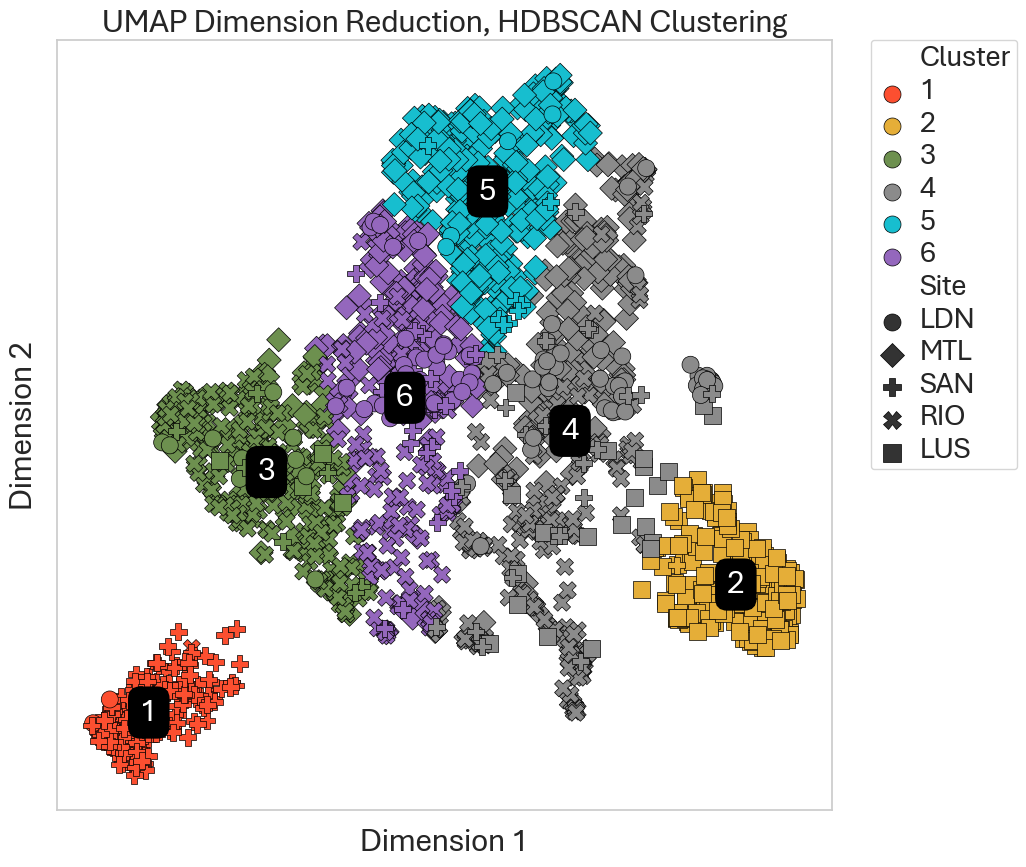

In [38]:
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title        = f"UMAP Dimension Reduction, HDBSCAN Clustering", centroids    = True, 
              size_by_prob = False, 
              ax           = None,
              centroid_kws = {"alpha": 1.0, "palette_dict":None, "show_edge": False},)


# plt.set_title(f"UMAP Dimension Reduction, HDBSCAN Clustering", fontproperties=prop, fontsize = 24)
# # plt.savefig(f"{figdir}/tsne-hdbscan-umap.png", dpi = 300, bbox_inches = 'tight')

#### Cluster by Site

In [39]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

cbs = cluster_by_site.copy()

# convert to percent of site
# cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

# sort the index by the order in site_name_dict
cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

print(cluster_by_site)

# output cluster_by_site to latex
# cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")
# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

Cluster      1      2      3      4      5      6
Site                                             
LDN        2.0    0.0   11.0   57.0    5.0   35.0
MTL        0.0    0.0   69.0  251.0  376.0  199.0
SAN      202.0    1.0    7.0   25.0    8.0   23.0
RIO        1.0    1.0  305.0  211.0    0.0  132.0
LUS        0.0  242.0    4.0   22.0    0.0    0.0


In [40]:
# sort by order in site_name_dict
cbs = cbs.loc[site_name_dict.values()]

# rename index values using site_fullname_dict
cbs.index = cbs.index.map(site_fullname_dict)
cbs = cbs.astype(int)

# cbs.to_latex(f"{reportdir}/basic-cluster-by-site.tex")

In [41]:
c1 = plot_df.groupby("Cluster")["Site"].value_counts(normalize = True).unstack().T.fillna(0)#.astype(int)
c1 = c1.loc[site_name_dict.values()]
c1

Cluster         1         2         3         4         5         6
Site                                                               
LDN      0.009756  0.000000  0.027778  0.100707  0.012853  0.089974
MTL      0.000000  0.000000  0.174242  0.443463  0.966581  0.511568
SAN      0.985366  0.004098  0.017677  0.044170  0.020566  0.059126
RIO      0.004878  0.004098  0.770202  0.372792  0.000000  0.339332
LUS      0.000000  0.991803  0.010101  0.038869  0.000000  0.000000

#### RFC Model to identify features that differentiate clusters

In [42]:
X.columns

Index(['CD-acute_kidney_injury___1', 'CD-acute_kidney_injury___2',
       'CD-acute_respiratory_distress___1',
       'CD-acute_respiratory_distress___2', 'CD-adjunctive___1',
       'CD-anemia___1', 'CD-anemia___2', 'CD-anxiety___1', 'CD-anxiety___2',
       'CD-asthma___1',
       ...
       'SYMPT-seizure___2', 'SYMPT-shortness_of_breath_dyspne___2',
       'SYMPT-skin_rash___2', 'SYMPT-sore_throat___2',
       'SYMPT-trouble_speaking_aphasia_d___2', 'SYMPT-weight_loss___2',
       'SYMPT-wheezing_or_stridor___2', 'VAX-vaccinated', 'age', 'sex'],
      dtype='object', length=246)

In [43]:
# use a random forest classifier to find the most important features
from sklearn.ensemble import RandomForestClassifier

# use all cores
clf = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )



# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy

boruta = BorutaPy(clf, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )
boruta.fit(X, cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100


BorutaPy finished running.

Iteration: 	33 / 100
Confirmed: 	38
Tentative: 	0
Rejected: 	208


BorutaPy(estimator=RandomForestClassifier(max_depth=7, n_estimators=127,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x315921640),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x315921640,
         verbose=1)

In [44]:
# make a subset of the data with the important features and 
# fit a classifiera on it, using the cluster labels as the target
important_features = X.columns[boruta.support_]
clf.fit(X[important_features], cluster_labels)

RandomForestClassifier(max_depth=7, n_estimators=127, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x315921640)

In [45]:
important_features

Index(['CD-fio2', 'CD-medication_received___1', 'CD-medication_received___3',
       'CD-medication_received___4', 'CD-medication_received___5',
       'CD-required_oxygen', 'CD-spo2', 'CD-type_of_care___2',
       'HHX-Arterial Hypertension', 'HHX-Coronary artery disease',
       'HHX-Diabetes', 'HHX-OTHER-Sleep-disorder', 'HHX-OTHER-hypo',
       'HHX-Obesity', 'HHX-Other', 'HHX-Psychiatric disease',
       'MED-Cardiovascular-agents', 'SITE', 'SYMPT-abdominal_pain___2',
       'SYMPT-chest_pain___2', 'SYMPT-confusion_altered_mental_s___2',
       'SYMPT-dizziness___2', 'SYMPT-ear_pain___2',
       'SYMPT-extremity_weakness_or_numb___2', 'SYMPT-fatigue___2',
       'SYMPT-fever_38_0oc___2', 'SYMPT-headache___2',
       'SYMPT-joint_pain_arthralgia___2', 'SYMPT-loss_of_appetite___2',
       'SYMPT-muscle_aches_myalgia___2', 'SYMPT-nausea_vomiting___2',
       'SYMPT-night_sweats___2', 'SYMPT-shortness_of_breath_dyspne___2',
       'SYMPT-sore_throat___2', 'SYMPT-weight_loss___2',
    

In [46]:
# plot_df.drop(columns = ["site"], inplace = True)
# plot_df["site"] = plot_df["Site"]

In [47]:
fi_df1 = make_feature_importance_df(clf, important_features)
features20 = make_topN_features(fi_df1, 20, feature_map, feature_colour_map)


In [48]:
features20

Feature  Importance  \
0                              Site    1.000000   
1                       LC+ Fatigue    0.836537   
2   LC+ Extremity Weakness/Numbness    0.748671   
3                       CoV Non-ICU    0.561310   
4                       LC+ Myalgia    0.483514   
5                    LC+ Arthralgia    0.411336   
6                     LC+ Dizziness    0.381382   
7                          CoV SpO2    0.354301   
8         LC+ Altered Mental Status    0.257090   
9                   CoV Antibiotics    0.216033   
10                       CoV Oxygen    0.186618   
11                  LC+ Weight Loss    0.185054   
12                PMHx Hypertension    0.175717   
13                       Vaccinated    0.138191   
14                      LC+ Dyspnea    0.131003   
15                     LC+ Headache    0.120536   
16                 PMHx Hypothyroid    0.120535   
17                 LC+ Night Sweats    0.113186   
18                              Age    0.107949   
19                       PMHx Other    0.099624   

                             OLD Feature                          Colour  
0                                   SITE                 [0.0, 0.0, 0.0]  
1                      SYMPT-fatigue___2  [0.392157, 0.266667, 0.380392]  
2   SYMPT-extremity_weakness_or_numb___2            [0.866667, 0.0, 1.0]  
3                    CD-type_of_care___2       [0.776471, 0.741176, 1.0]  
4         SYMPT-muscle_aches_myalgia___2       [0.584314, 0.827451, 1.0]  
5        SYMPT-joint_pain_arthralgia___2       [0.807843, 0.521569, 1.0]  
6                    SYMPT-dizziness___2  [0.784314, 0.509804, 0.435294]  
7                                CD-spo2       [0.058824, 1.0, 0.662745]  
8   SYMPT-confusion_altered_mental_s___2       [0.670588, 0.447059, 0.0]  
9             CD-medication_received___5  [0.580392, 0.403922, 0.741176]  
10                    CD-required_oxygen  [0.121569, 0.466667, 0.705882]  
11                 SYMPT-weight_loss___2        [1.0, 0.47451, 0.560784]  
12             HHX-Arterial Hypertension  [0.258824, 0.313725, 0.321569]  
13                        VAX-vaccinated  [0.513725, 0.827451, 0.443137]  
14  SYMPT-shortness_of_breath_dyspne___2   [0.32549, 0.270588, 0.545098]  
15                    SYMPT-headache___2  [0.921569, 0.815686, 0.607843]  
16                        HHX-OTHER-hypo  [0.015686, 0.890196, 0.784314]  
17                SYMPT-night_sweats___2       [1.0, 0.501961, 0.007843]  
18                                   age   [0.564706, 0.619608, 0.74902]  
19                             HHX-Other            [1.0, 1.0, 0.603922]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Site is in the list of features


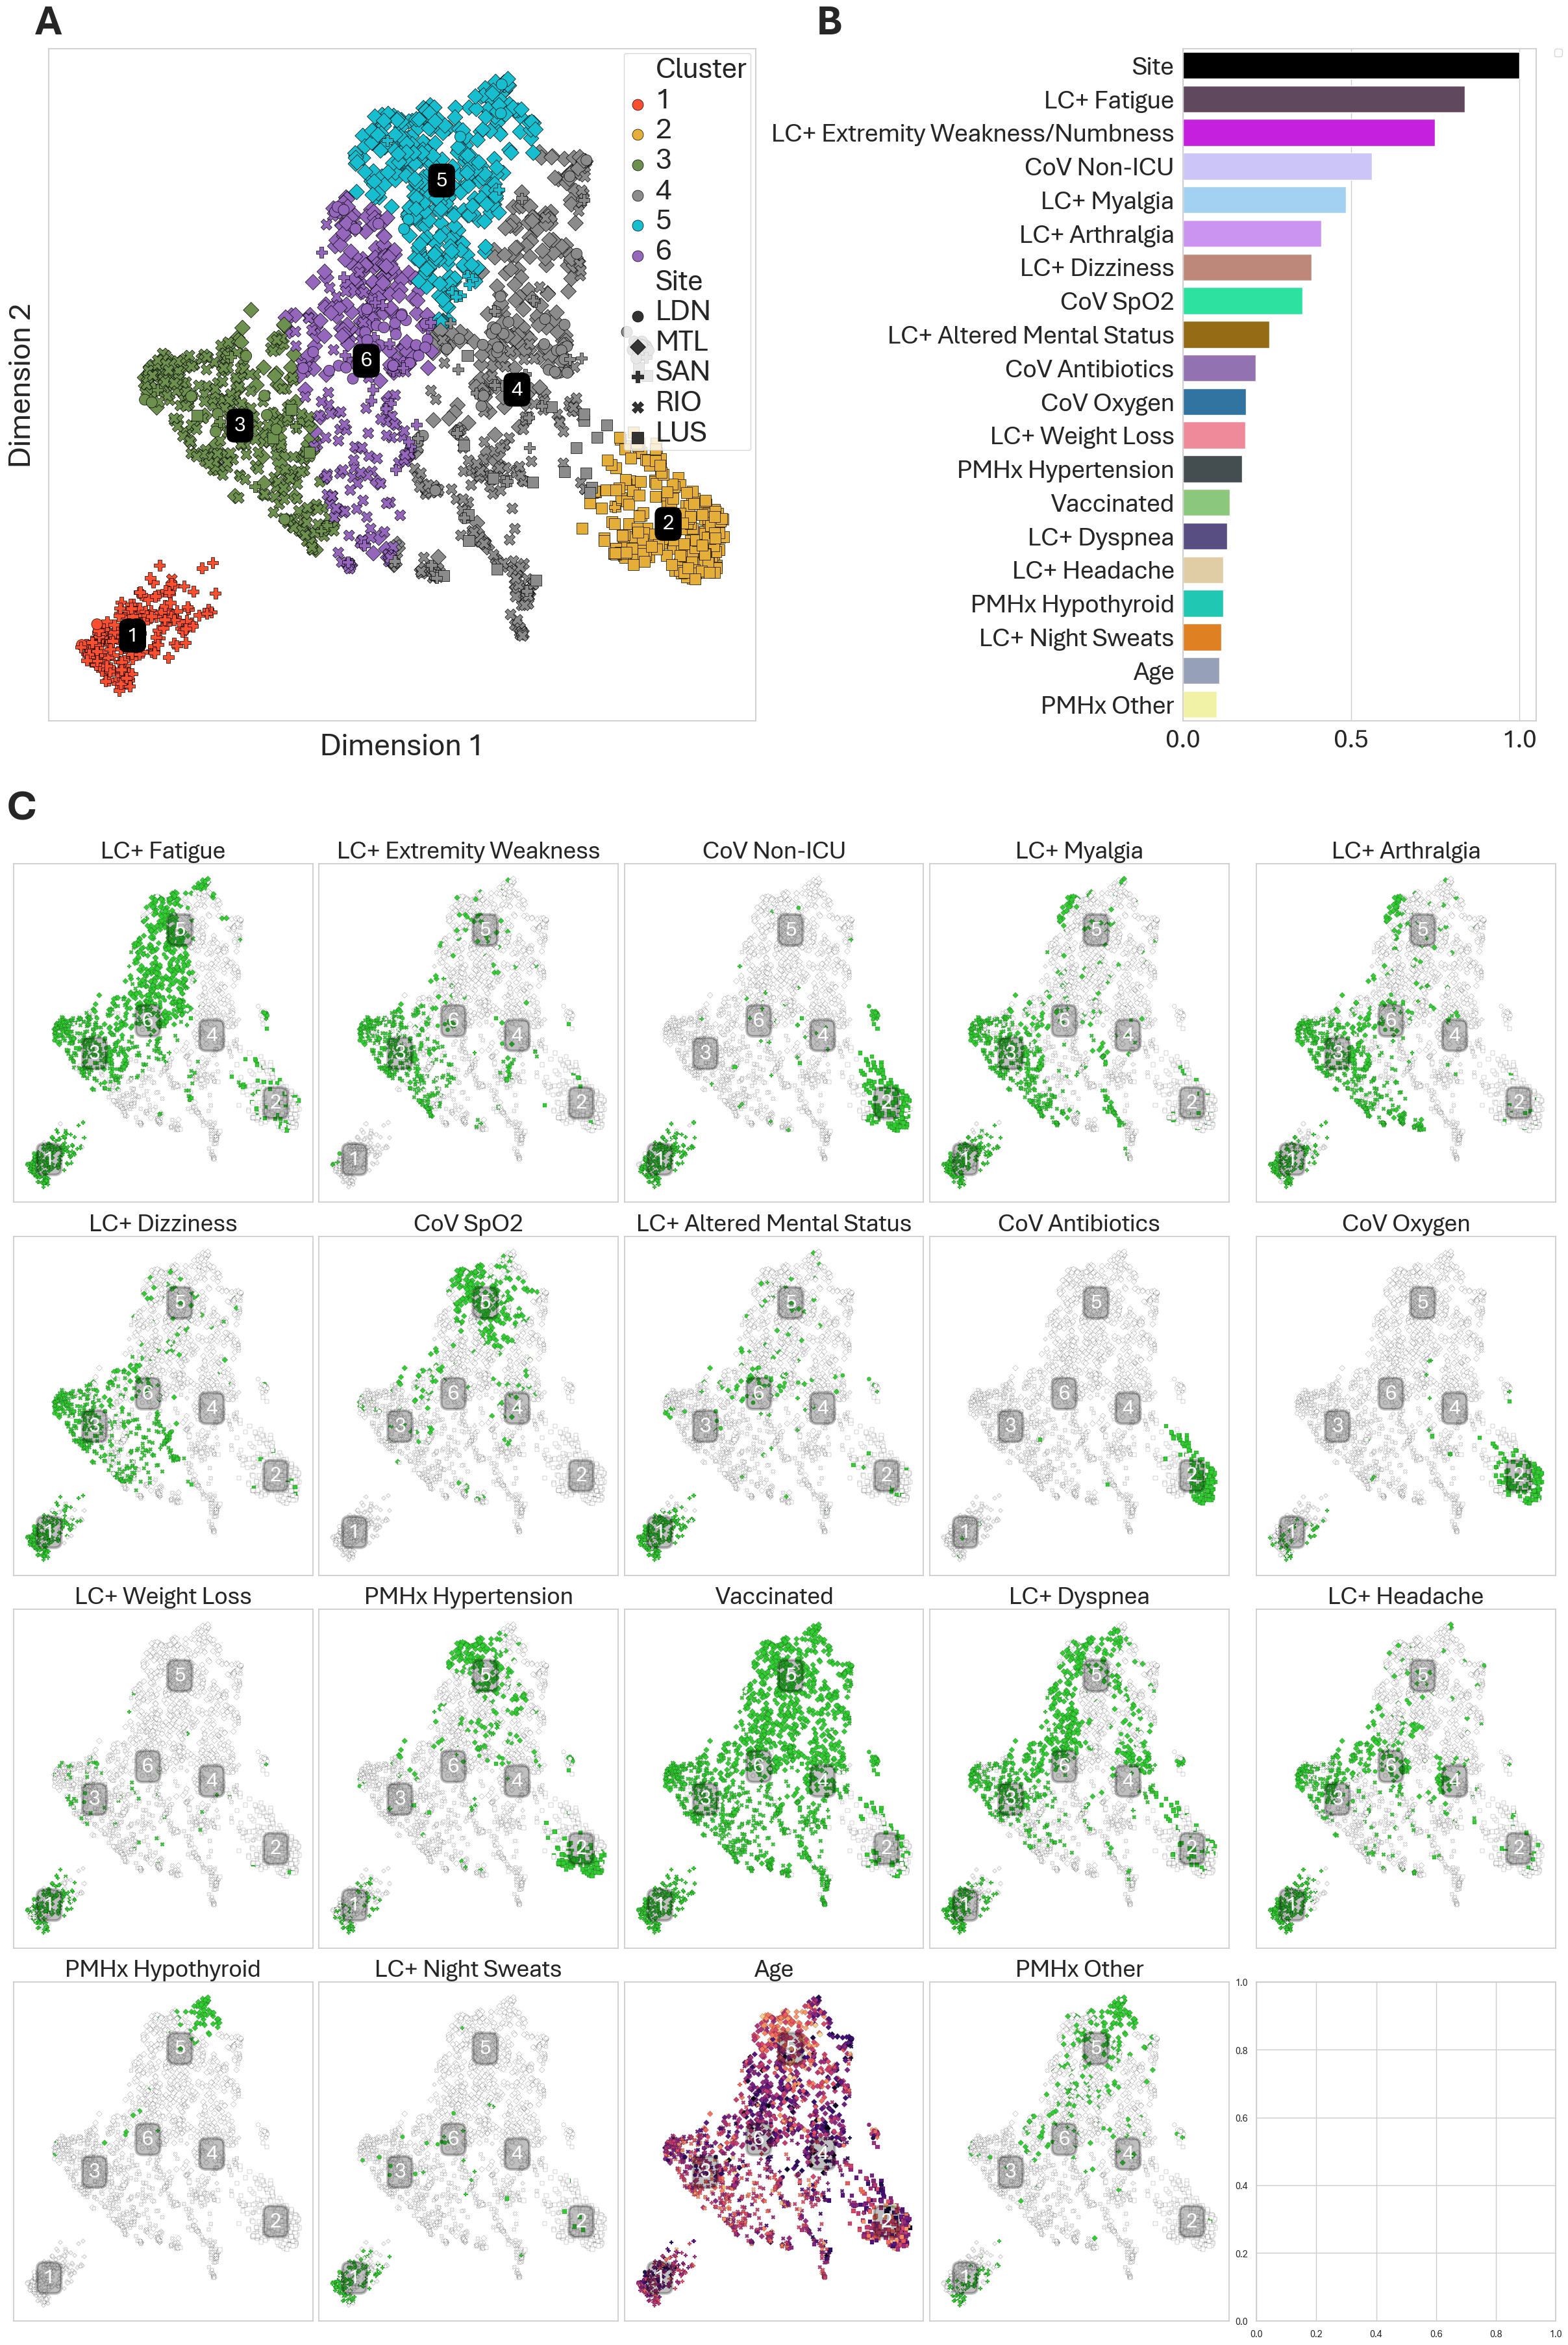

In [49]:
fig     = plt.figure(layout="constrained", figsize=(24,36))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[2,4], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = None, 
              centroids = True, 
              size_by_prob = False, 
              ax = axs0[0],
              FONTSIZE = FONTSIZE*1.5,)
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )

plot_feature_importances(features20, 
                         feature_map, 
                         feature_colour_map, 
                         axs0[1], 
                         FONTSIZE*1.25)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
axs1 = subfigs[1].subplots(4,5)

plot_multiple_features(fi_df1, 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        fontsize = FONTSIZE*1.2,
                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = False

if SAVE:

    for dpi in [600, 300]:

        fn = f"{figdir}/ALL-FI-{n_clusters_ALL}c-{dpi}dpi-{timestamp}.png"
        print(fn)
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')



### Excursion Plots

In [50]:
# make a table of features and their importances from the classifier
fi_df = pd.DataFrame(clf.feature_importances_, 
                     index = clf.feature_names_in_, 
                     columns = ["Importance"])

# fi_df = make_feature_importance_df(clf, important_features)

# make a table of all of the features and their rankings
feature_ranking_table = pd.DataFrame({
                        "Feature": X.columns, 
                        "Ranking": boruta.ranking_, 
                        "Importance":boruta.support_, })


# fill fff with the feature importances
# start with zero
feature_ranking_table["FI"] = 0.0

# now fill in the numeric values for the important features
for i, f in feature_ranking_table.iterrows():
    if f["Importance"] == True:
        # print(i,f["Feature"], fi_df.loc[f["Feature"]]["Importance"])
        feature_ranking_table.loc[i, "FI"] = fi_df.loc[f["Feature"]]["Importance"]

# sort by FI
feature_ranking_table.sort_values(by = "FI", ascending = False, inplace = True)

In [51]:
# save the cluster labels to a copy of the original dataframe
A = X.copy()
M = X.copy()

# sosrt columns in the order set in fff
M = M[feature_ranking_table["Feature"]]

# augment with cluster labels
A["cluster"] = [c+1 for c in cluster_labels]
M["cluster"] = [c+1 for c in cluster_labels]


In [52]:
cluster_by_site

Cluster      1      2      3      4      5      6
Site                                             
LDN        2.0    0.0   11.0   57.0    5.0   35.0
MTL        0.0    0.0   69.0  251.0  376.0  199.0
SAN      202.0    1.0    7.0   25.0    8.0   23.0
RIO        1.0    1.0  305.0  211.0    0.0  132.0
LUS        0.0  242.0    4.0   22.0    0.0    0.0

In [53]:
cluster_membership_by_site = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cluster_membership_by_site.index.name = "cluster"

# map the site_fullname_dict to the index
cluster_membership_by_site.columns = cluster_membership_by_site.columns.map(site_fullname_dict)
cluster_membership_by_site = cluster_membership_by_site.T
# round to 1 decimal place
cluster_membership_by_site = cluster_membership_by_site.round(1)

cluster_membership_by_site

cluster            1     2     3     4     5     6
Site                                              
London           1.8   0.0  10.0  51.8   4.5  31.8
Montreal         0.0   0.0   7.7  28.0  42.0  22.2
San Diego       75.9   0.4   2.6   9.4   3.0   8.6
Rio de Janeiro   0.2   0.2  46.9  32.5   0.0  20.3
Lusaka           0.0  90.3   1.5   8.2   0.0   0.0

In [55]:
feature_prev_by_cluster = M.groupby("cluster").mean()

# get the first 20 columns
feature_prev_by_cluster = feature_prev_by_cluster[feature_ranking_table["Feature"][:20]]

# rename the columns
for c in feature_prev_by_cluster.columns:
    feature_prev_by_cluster.rename(columns = {c: feature_map[c]}, inplace = True)

# drop age and sex
# feature_prev_by_cluster = feature_prev_by_cluster.drop(columns = ["Age", "Sex"])
feature_prev_by_cluster = feature_prev_by_cluster.drop(columns = ["Age"])

In [56]:
feature_prev_by_cluster

Site  LC+ Fatigue  LC+ Extremity Weakness/Numbness  CoV Non-ICU  \
cluster                                                                        
1        0.496341     0.985366                         0.019512     0.926829   
2        0.996926     0.180328                         0.028689     0.782787   
3        0.640152     0.813131                         0.803030     0.015152   
4        0.451413     0.118375                         0.061837     0.068905   
5        0.251928     0.717224                         0.082262     0.007712   
6        0.411954     0.773779                         0.156812     0.028278   

         LC+ Myalgia  LC+ Arthralgia  LC+ Dizziness  CoV SpO2  \
cluster                                                         
1           0.839024        0.721951       0.829268  0.000000   
2           0.057377        0.045082       0.036885  0.000000   
3           0.871212        0.830808       0.709596  0.085859   
4           0.118375        0.079505       0.068905  0.083039   
5           0.143959        0.156812       0.095116  0.573265   
6           0.197943        0.313625       0.349614  0.082262   

         LC+ Altered Mental Status  CoV Antibiotics  CoV Oxygen  \
cluster                                                           
1                         0.887805         0.014634    0.234146   
2                         0.040984         0.622951    0.643443   
3                         0.053030         0.002525    0.007576   
4                         0.033569         0.005300    0.019435   
5                         0.071979         0.000000    0.005141   
6                         0.143959         0.000000    0.000000   

         LC+ Weight Loss  PMHx Hypertension  Vaccinated  LC+ Dyspnea  \
cluster                                                                
1               0.731707           0.297561    0.956098     0.721951   
2               0.008197           0.520492    0.250000     0.233607   
3               0.106061           0.045455    0.934343     0.651515   
4               0.008834           0.097173    0.943463     0.247350   
5               0.002571           0.483290    0.982005     0.393316   
6               0.033419           0.077121    0.964010     0.591260   

         LC+ Headache  PMHx Hypothyroid  LC+ Night Sweats  PMHx Other  
cluster                                                                
1            0.839024          0.000000          0.595122    0.331707  
2            0.081967          0.000000          0.024590    0.004098  
3            0.479798          0.007576          0.017677    0.047980  
4            0.132509          0.000000          0.003534    0.047703  
5            0.079692          0.187661          0.007712    0.380463  
6            0.334190          0.015424          0.030848    0.149100

./OUTPUT/lc-pos-figures/2025-02-02/ALL-FPrev-by-cluster-6c-600dpi-2025-02-02.png
./OUTPUT/lc-pos-figures/2025-02-02/ALL-FPrev-by-cluster-6c-300dpi-2025-02-02.png


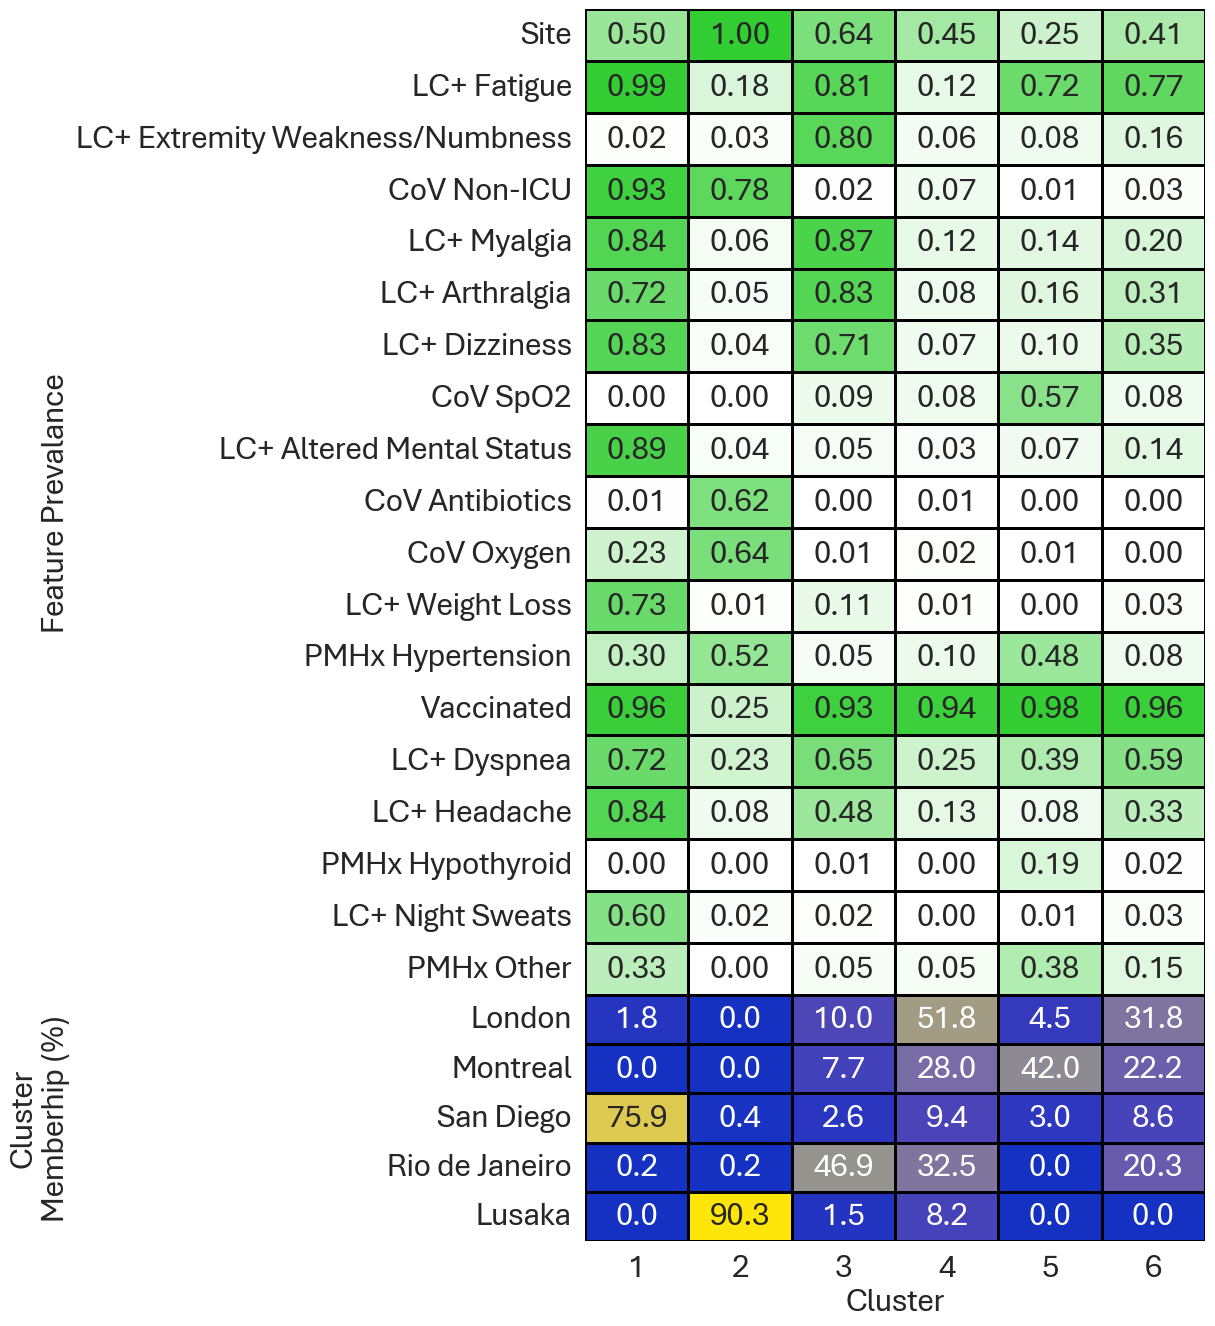

In [57]:


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(8,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

sns.heatmap(feature_prev_by_cluster.T, 
            cmap = cmap, 
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 24}
)

# turn off the xticks and x label
axs0.set_xticks([]); axs0.set_xlabel("")

sns.heatmap(cluster_membership_by_site,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 24}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

# output the figure
# plt.savefig(f"{figdir}/feature-prevalence-by-cluster-600.png", dpi = 600, bbox_inches = 'tight')
# plt.savefig(f"{figdir}/feature-prevalence-by-cluster-300.png", dpi = 300, bbox_inches = 'tight')

for dpi in [600, 300]:

    fn = f"{figdir}/ALL-FPrev-by-cluster-{n_clusters_ALL}c-{dpi}dpi-{timestamp}.png"
    print(fn)
    plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')


# By SITE for subphenotypes at each site

In [58]:
# select the columns to use
LC_COLUMNS = LC_pos_.columns

# remove SITE from LC_COLUMNS
LC_COLUMNS = LC_COLUMNS.drop(["SITE", "age"])

In [59]:
# cluster pipeline, iterating over the sites

result_dict = {}

for i, (k,v) in enumerate(site_name_dict.items()):
    # print(i, k, v)

    print(f"Site {k}: {v}")

    # LC_pos_ = df.query(f"SITE == {k}").copy()
    the_data = LC_pos_.query(f"SITE == {k}").copy()

    # drop age
    the_data = the_data.drop(columns = ["age"])


    X = scaler.fit_transform(the_data)     # type: ignore
    X = X.dropna(axis = 0)
    X = X[LC_COLUMNS]

    print(f"Data shape = {the_data.shape}")
    print(f"X shape    = {X.shape}")


    # reduce and cluster
    # sklearn pipelines
    min_cluster_size = int(np.sqrt(X.shape[0]))

    hdb_parms = {
                    # min_cluster_size is roughly 
                    # sqrt(n) where n is the number of samples
                    'min_cluster_size': min_cluster_size, 
                    'min_samples': min_cluster_size,
                    'cluster_selection_method': 'leaf', # more granular
                    'cluster_selection_epsilon': 0.1,
                }

    umap_parms = {
                    'n_components': 2,
                    'spread':       1.0,
                    'random_state': 42,
                    # 'metric':      'euclidean',
                    # 'metric':      'hamming',
                    'verbose':      False
                }

    # turn off userwarnings from umap
    import warnings
    warnings.filterwarnings("ignore")
    
    # instantiate the pipeline
    pipe = Pipeline([
                    ('scaler', MinMaxScaler()),
                    ('embed', UMAP(**umap_parms)),
                    ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                    ])

    # apply to the feature dataframe
    pipe.fit(X)

    # get the plot dataframe and cluster labels
    sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
    plot_df, cluster_labels = make_plot_df(pipe, sites, site_name_dict)

    # what fraction of the data is in each cluster?
    # print(plot_df["Cluster"].value_counts(normalize = True)*100)

    # use all cores
    clf = RandomForestClassifier(n_jobs=-1, 
                                #  n_estimators = 100, 
                                #  class_weight='balanced', 
                                max_depth=7
                                )

    # instantiate the Boruta feature selector
    from boruta_py.boruta import BorutaPy

    boruta = BorutaPy(clf, 
                    #   n_estimators = 1_000, 
                    n_estimators = 'auto',
                    verbose      = 0, 
                    random_state = 42, 
                    perc         = 100
                    )
    boruta.fit(X, cluster_labels)

    # make a subset of the data with the important features and 
    # fit a classifiera on it, using the cluster labels as the target
    important_features = X.columns[boruta.support_]
    clf.fit(X[important_features], cluster_labels)

    # print(important_features, clf.feature_importances_)

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()

    # # sosrt columns in the order set in fff
    M = M[important_features]

    # # augment with cluster labels
    M["cluster"] = [c+1 for c in cluster_labels]

    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()



    case_dict = {'plot_df': plot_df, 
                 'important_features': important_features,
                 'mfv': mfv,
                 'classifier': clf, 
                 'boruta': boruta, 
                 'X': X,
                 'cluster_labels': cluster_labels,
                 }

    result_dict.update({v: case_dict})

# plt.show()

Site 1: LDN
Data shape = (110, 245)
X shape    = (110, 244)
Site 2: MTL
Data shape = (895, 245)
X shape    = (895, 244)
Site 3: SAN
Data shape = (266, 245)
X shape    = (266, 244)
Site 4: RIO
Data shape = (651, 245)
X shape    = (650, 244)
Site 5: LUS
Data shape = (272, 245)
X shape    = (272, 244)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, -1.3885555555556035, 'Relative Importance')

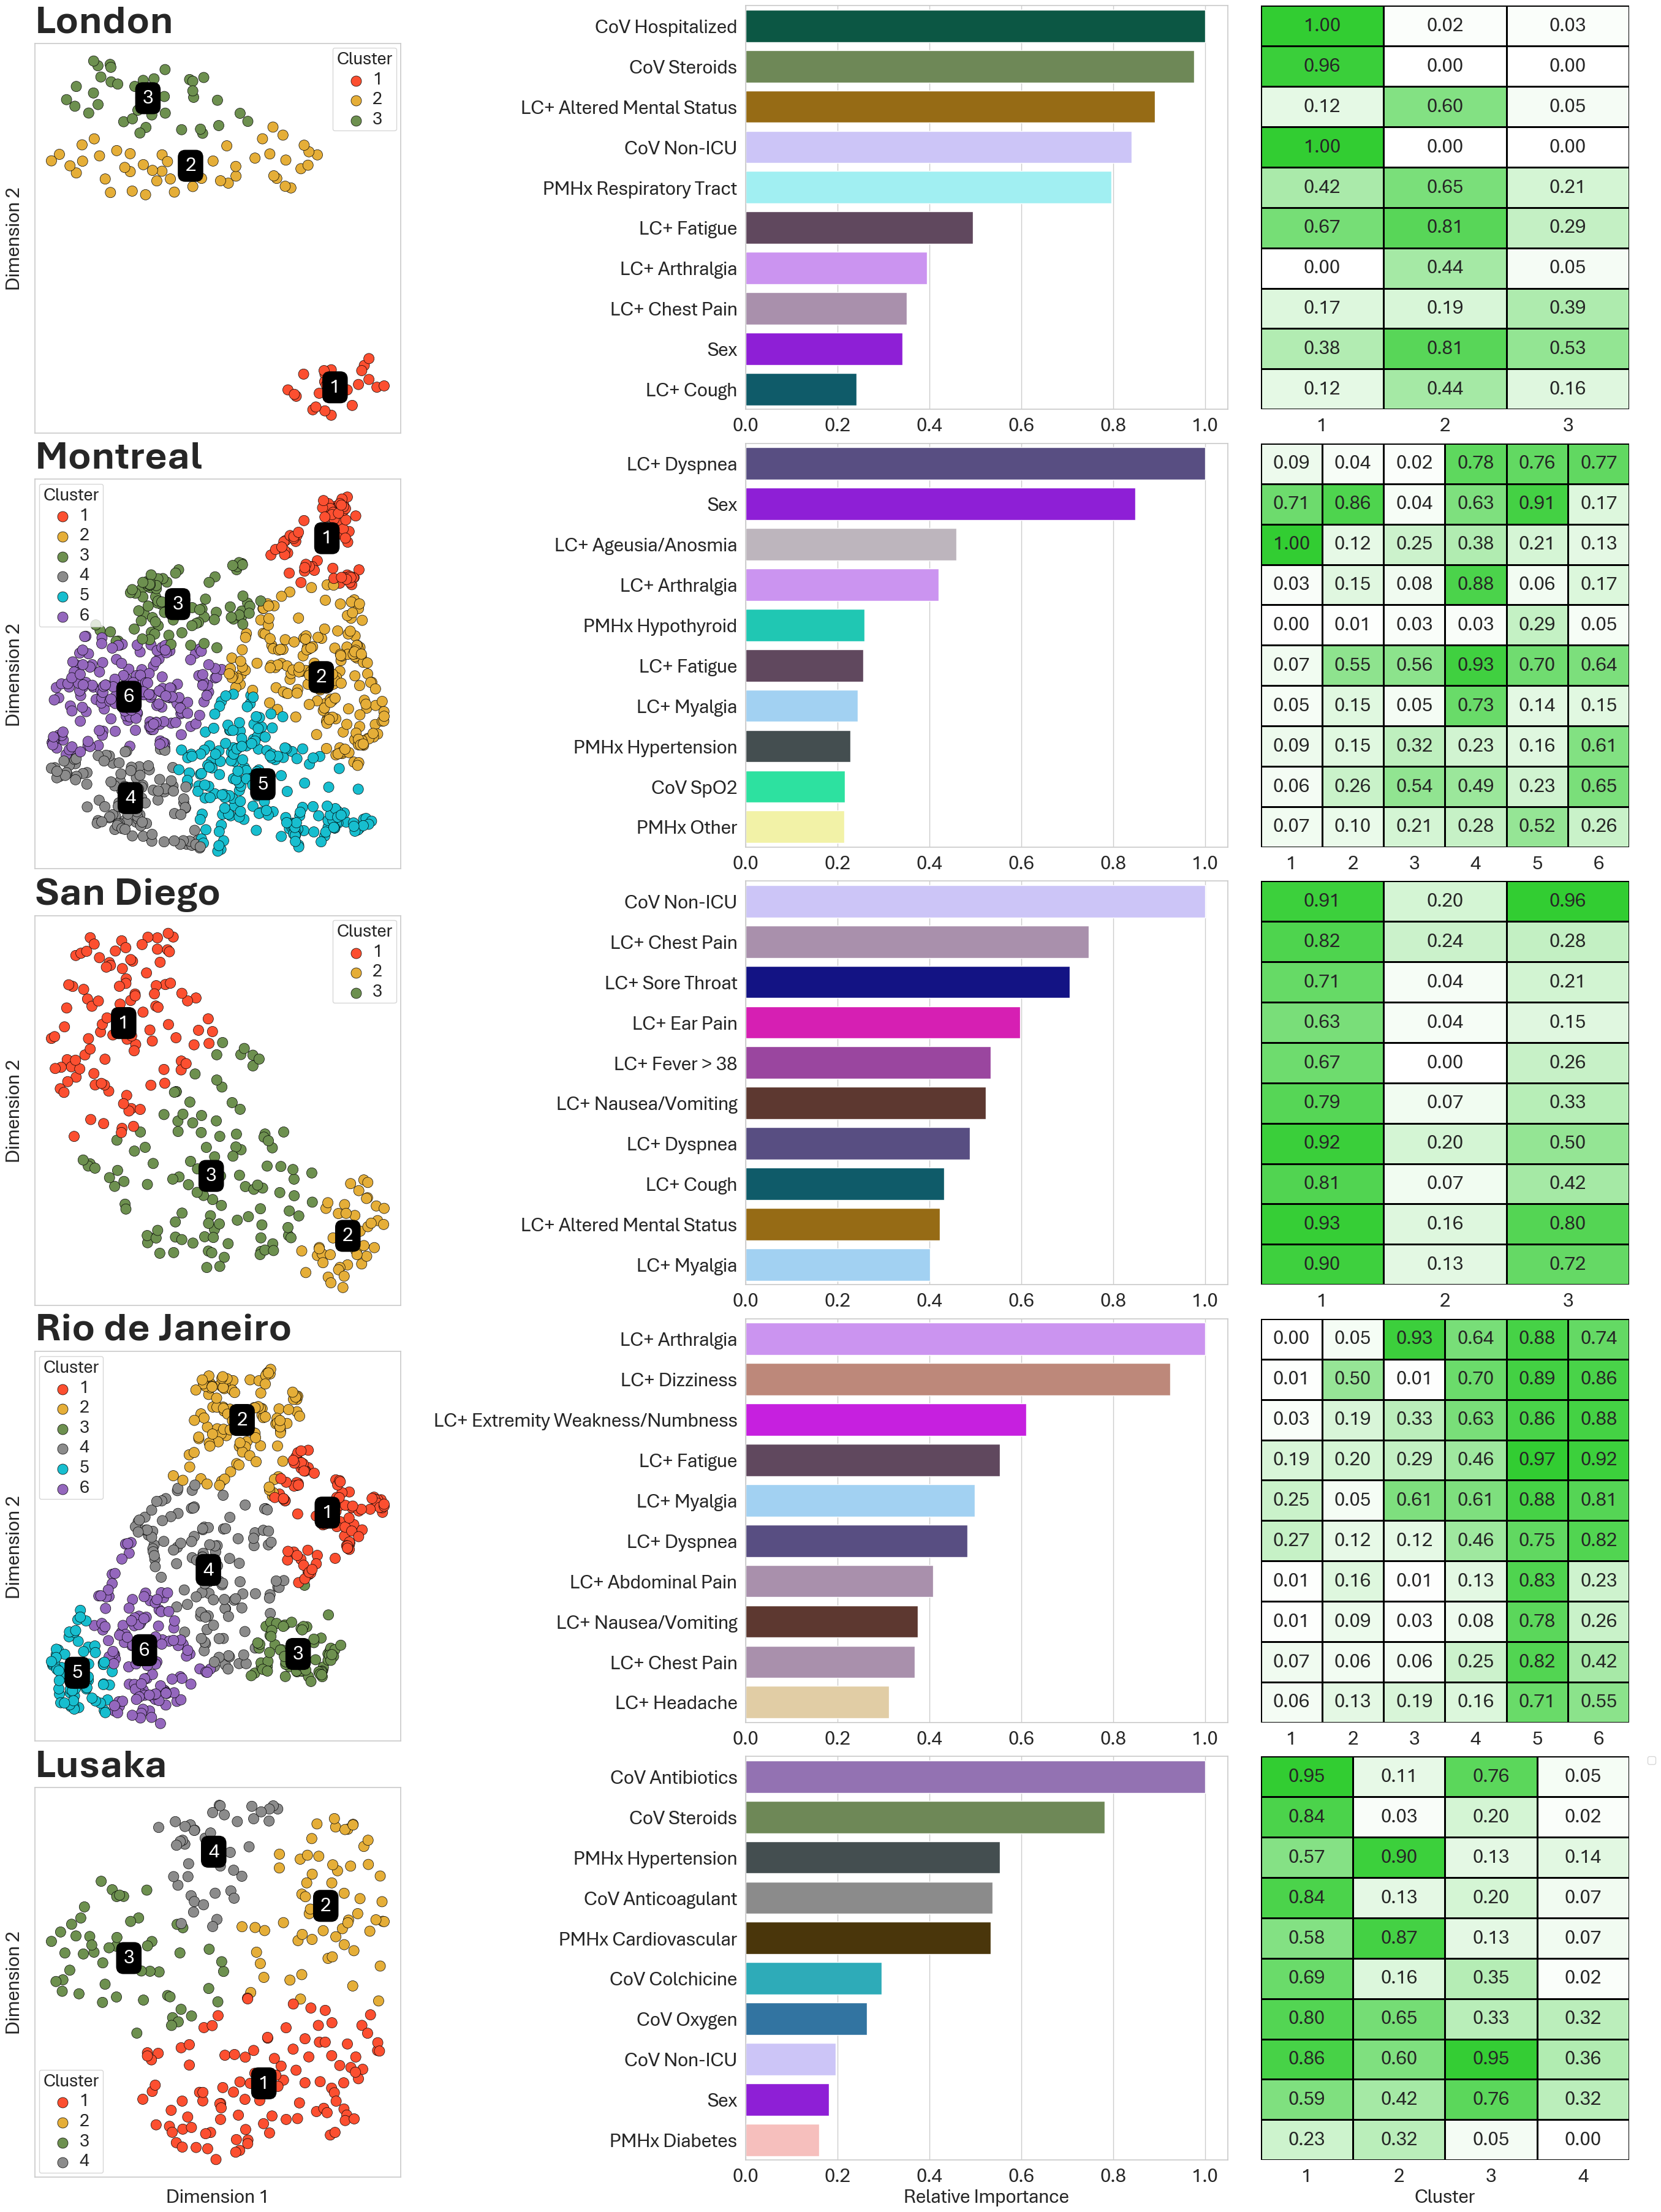

In [60]:
# make the figure

fig     = plt.figure(layout="constrained", figsize=(27,36), )
subfigs = fig.subfigures(1,3, wspace=0.05, hspace = 0.1, width_ratios=[1,2,1])

axl = subfigs[0].subplots(5, 1)
axc = subfigs[1].subplots(5, 1, sharex = False)
axr = subfigs[2].subplots(5, 1, sharex = False)

for i,item in enumerate(result_dict.items()):

    k, v = item

    plot_df            = v['plot_df']
    important_features = v['important_features']
    X                  = v['X']

    # clusters
    plot_clusters(plot_df, 
                  site_name_dict, 
                  palette_dict,
                  title        = None, 
                  centroids    = True, 
                  size_by_prob = False, 
                  ax           = axl[i], 
                  style        = None
                  )
    # turn off the x label
    axl[i].set_xlabel("", fontsize = FONTSIZE)

    # feature importances
    fi_df = make_feature_importance_df(v['classifier'], v['important_features'])
    # select only the top10 features
    features10 = make_topN_features(fi_df, 
                                    10, 
                                    feature_map, 
                                    feature_colour_map)

    plot_feature_importances(features10, 
                             feature_map, 
                             feature_colour_map, 
                             axc[i], 
                             FONTSIZE)

    # the mean feature values
    # mfv = X[important_features].mean()

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()
    M = M[important_features]
    # # augment with cluster labels
    M["cluster"] = [c+1 for c in v['cluster_labels']]
    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()


    # sort the mfv columns by the order of the important features
    mfv = mfv[features10["OLD Feature"]]

    # print(features10["Feature"], features10["OLD Feature"])

    # print(mfv)

    # map the feature names to the new names
    mfv.columns = features10["Feature"]

    # heatmaps
    sns.heatmap(mfv.T,
                cmap = cmap, 
                # ax = ax, 
                cbar = False, 
                vmin = 0, 
                linewidth = 1, 
                # linewidth = 0.5, 
                square = False, 
                linecolor = 'k',
                annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 24},
                ax = axr[i]
    )

    # turn off the y axis label
    axr[i].set_ylabel("", fontsize = FONTSIZE)

    # turn off y ticks
    axr[i].set_yticks([])

    #make tick labels larger
    axr[i].tick_params(axis='both', which='major', labelsize=FONTSIZE)
    axr[i].set_xlabel("", fontsize = FONTSIZE)


    axl[i].annotate(f"{site_fullname_dict[k]}",
                        xy=(0.0, 1.01), 
                        xycoords='axes fraction',
                        xytext=(0.0,0.0), 
                        textcoords = 'offset points',
                        fontsize = FONTSIZE*2,
                        horizontalalignment='left', 
                        verticalalignment='bottom',
                        fontweight = "bold",
                        )



axl[4].set_xlabel("Dimension 1", fontsize = FONTSIZE)
axr[4].set_xlabel("Cluster", fontsize = FONTSIZE)
axc[4].set_xlabel("Relative Importance", fontsize = FONTSIZE)

# for dpi in [600, 300]:

#     fn = f"{figdir}/SUBPHENOTYPE-ALL-FI-by-site-{dpi}dpi-{timestamp}.png"
#     print(fn)
#     plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')




# By SYMPTOM Status

In [61]:
# we need to agglomorate into a reasonable number of clusters
# this factor does so
factor = 3

In [62]:
# list of feature names that are symptoms that are new or worse in the LC+ population
lc_symptoms = [f for f in LC_pos_.columns if f.startswith("SYMPT-") and f.endswith("___2")]

In [63]:
# select only the features in new_and_worse
X = LC_pos_[lc_symptoms].copy()
print(X.shape)

# drop rows with missing values
X.dropna(inplace = True, axis = 0)
print(X.shape)

# drop rows with all zeros
# X = X.loc[(X != 0).any(axis = 1)]
print(X.shape)

(2194, 28)
(2194, 28)
(2194, 28)


In [64]:
# # drop certain features

# # drop features that contain adjunctive
# X = X.drop(columns = X.filter(regex = 'adjunctive').columns)

# # drop features that contain "medication_received"
# X = X.drop(columns = X.filter(regex = 'medication_received').columns)

# # drop features that contain "type_of_care"
# X = X.drop(columns = X.filter(regex = 'type_of_care').columns)

# # drop features that contain "ventilatory_support_type"
# X = X.drop(columns = X.filter(regex = 'ventilatory_support_type').columns)

# print(X.shape)

In [65]:
# cluster pipeline


min_cluster_size = int(np.sqrt(X.shape[0]))*factor

print(f"MCS = {min_cluster_size}")



hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples':      min_cluster_size,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.5,
            }

umap_parms = {
                'n_components': 2,
                'spread':       1.0,
                'random_state': 42,
                'min_dist':     0.25,
                # 'metric': 'cosine',
                # 'metric': 'hamming',
            }

# define the transformer
umap_transformer = UMAP(**umap_parms, verbose = True)
embedding_model = umap_transformer

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', embedding_model),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# get the dataframe and the labels
sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
plot_df, cluster_labels = make_plot_df(pipe, sites, site_name_dict)

n_clust = max(cluster_labels)+1

MCS = 138
UMAP(min_dist=0.25, random_state=42, verbose=True)
Sun Feb  2 13:49:07 2025 Construct fuzzy simplicial set
Sun Feb  2 13:49:09 2025 Finding Nearest Neighbors
Sun Feb  2 13:49:09 2025 Finished Nearest Neighbor Search
Sun Feb  2 13:49:09 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Feb  2 13:49:17 2025 Finished embedding


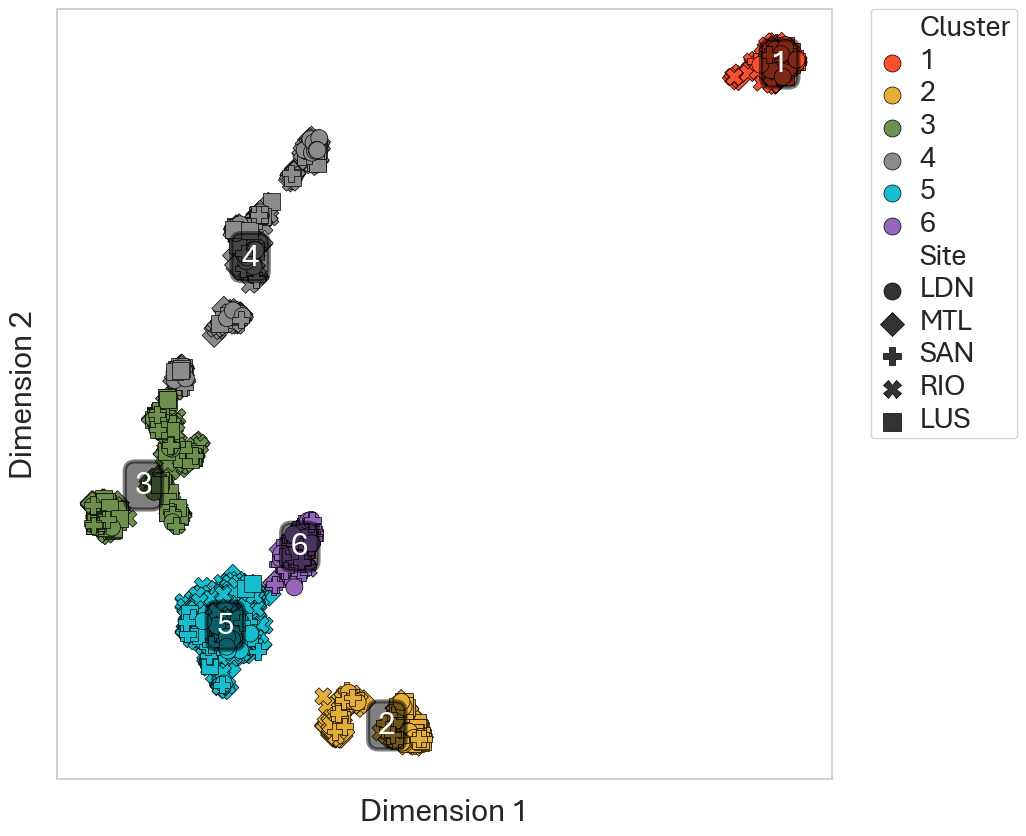

In [66]:
# plot the clusters
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
            #   title = f"New and Worsening Symptoms only, N = {X.shape[0]:2d}", 
            #   title = f"New and Worsening Symptoms only, N = {X.shape[0]:2d}", 
              centroids = True, 
              size_by_prob = False, 
              ax = None,
              centroid_kws = {"alpha": 0.5, "palette_dict":None, "show_edge": True},)


In [67]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

cbs = cluster_by_site

# divid by the row sum
cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

In [68]:
# intresting featurs
intfeat = [f for f in mfv.columns if f in new_and_worse]
intfeat = [
 'SYMPT-confusion_altered_mental_s___2',
 'SYMPT-joint_pain_arthralgia___2',
 'SYMPT-cough___2',
 'SYMPT-shortness_of_breath_dyspne___2',
 'SYMPT-dizziness___2',
 'SYMPT-fatigue___2',
 'SYMPT-headache___2',
 'SYMPT-muscle_aches_myalgia___2',
]

ifn = [str.split(feature_map[f], "LC+ ")[1] for f in intfeat]

In [69]:
# join X with site to calculate the mean value of each feature per site
M = X.copy()

# augment with site labels
M["SITE"] = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# get the mean value of each feature per site
mfv = M.groupby("SITE").mean()

# sort the mfv columns by the order of the important features
mfv = mfv[sorted(lc_symptoms)]

# select only columns in intfeat
mfv = mfv[intfeat]

# map names in intfeat to the feature_map
mfv.columns = [str.split(feature_map[f], "LC+ ")[1] for f in intfeat]
mfv


Altered Mental Status  Arthralgia     Cough   Dyspnea  Dizziness  \
SITE                                                                     
LDN                0.309091    0.209091  0.272727  0.618182   0.181818   
LUS                0.033088    0.058824  0.297794  0.231618   0.040441   
MTL                0.080447    0.210056  0.216760  0.464804   0.138547   
RIO                0.004608    0.499232  0.245776  0.422427   0.516129   
SAN                0.744361    0.620301  0.518797  0.616541   0.684211   

       Fatigue  Headache   Myalgia  
SITE                                
LDN   0.600000  0.236364  0.154545  
LUS   0.202206  0.088235  0.069853  
MTL   0.606704  0.220112  0.201117  
RIO   0.491551  0.281106  0.508449  
SAN   0.875940  0.710526  0.691729

In [70]:
# pikle the results
mfv.to_pickle(f"./sites-symptoms.pkl")

In [71]:
ifn

['Altered Mental Status',
 'Arthralgia',
 'Cough',
 'Dyspnea',
 'Dizziness',
 'Fatigue',
 'Headache',
 'Myalgia']

In [72]:
# sort by order in site_name_dict
cbs = cbs.loc[site_name_dict.values()]

# rename index values using site_fullname_dict
cbs.index = cbs.index.map(site_fullname_dict)
cbs = cbs.astype(int)

cbs.to_latex(f"{reportdir}/SYMPTOM-only-cluster-by-site-{n_clust}.tex")

In [73]:
cluster_membership_by_site = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cluster_membership_by_site.index.name = "cluster"

# map the site_fullname_dict to the index
cluster_membership_by_site.columns = cluster_membership_by_site.columns.map(site_fullname_dict)
cluster_membership_by_site = cluster_membership_by_site.T
# round to 1 decimal place
cluster_membership_by_site = cluster_membership_by_site.round(1)

# sort by the order in site_name_dict
cluster_membership_by_site = cluster_membership_by_site.loc[site_fullname_dict.values()]

cluster_membership_by_site

cluster            1     2     3     4     5     6
Site                                              
London          19.1  15.5   9.1  37.3  10.9   8.2
Montreal        17.2  22.3  12.0  30.4  17.7   0.4
San Diego        2.6   7.5   7.1   5.6   6.0  71.1
Rio de Janeiro   4.1   5.5  26.3  11.1  52.8   0.2
Lusaka           4.0  13.2  44.9  35.3   2.6   0.0

In [74]:
# save cbsm to a pickle file
cluster_membership_by_site.to_pickle(f"./SYMPTOM-only-cluster-by-site-{n_clust}.pkl")

In [75]:
# find important features

# classifier
clf2 = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )

# boruta
boruta = BorutaPy(clf2, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )

# fit, with the cluster_labels as targets
boruta.fit(X, cluster_labels)

# get the important features
important_features = X.columns[boruta.support_]

# now fit the classifier on these features
clf2.fit(X[important_features], cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

RandomForestClassifier(max_depth=7, n_estimators=96, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x3159AA940)

In [76]:
# dataframes with the feature importance and topN features
fi_df = make_feature_importance_df(clf2, important_features)
top_features = make_topN_features(fi_df, 20, feature_map, feature_colour_map)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


UnboundLocalError: cannot access local variable 'int_feat' where it is not associated with a value

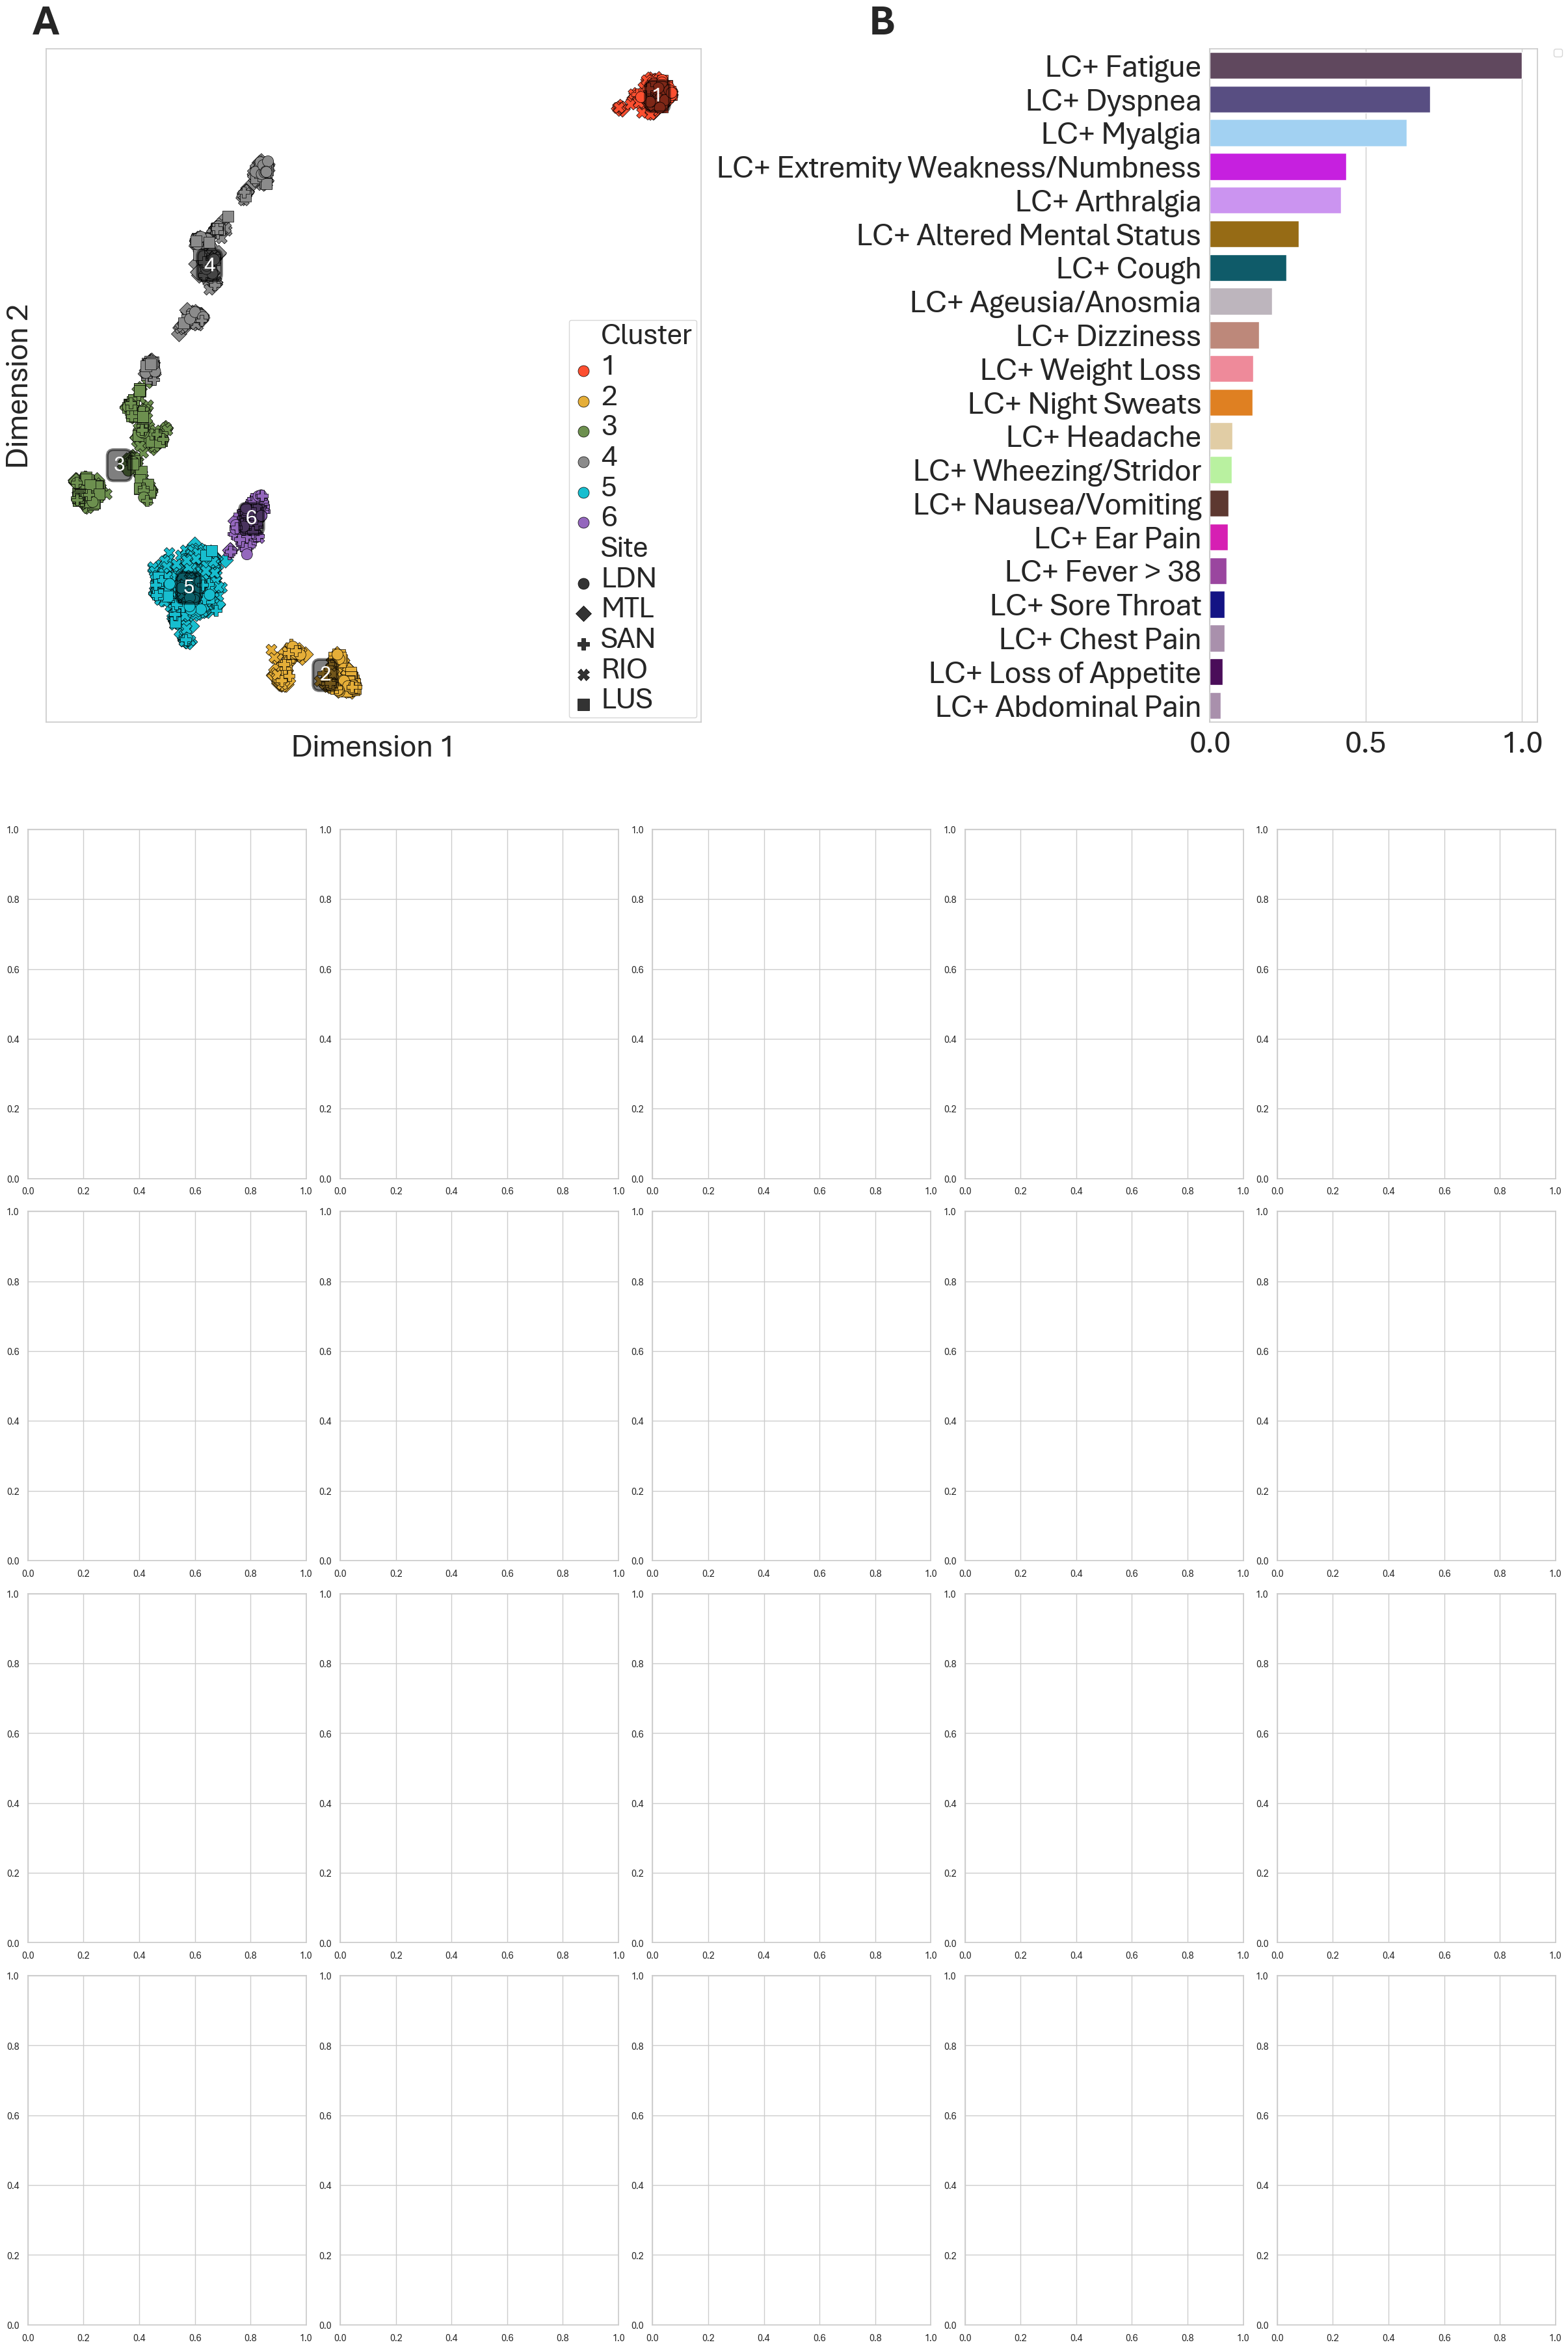

In [77]:
# plot

# make an array of axes for the second subfigure
# get the number of top_features
n = len(top_features)
n_rows = int(np.ceil(n/5))

# h_factor = 

fig     = plt.figure(layout="constrained", figsize=(24,36))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[1,2], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = None, 
              centroids = True, 
              size_by_prob = False, 
              ax = axs0[0],
              FONTSIZE = FONTSIZE*1.5,
              centroid_kws = {"alpha": 0.5, "palette_dict":None, "show_edge": False},)

# save just this plot
# plt.savefig(f"{figdir}/SYMPTOM-UMAP-HDBSCAN.png", dpi = 300, bbox_inches = 'tight')

# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


plot_feature_importances(top_features, 
                         feature_map, 
                         feature_colour_map, 
                         axs0[1], 
                         FONTSIZE*1.5)
# @ save just this plot
plt.savefig(f"{figdir}/SYMPTOM-FI.png", dpi = 300, bbox_inches = 'tight')


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
# get the number of top_features
n = len(top_features)

axs1 = subfigs[1].subplots(n_rows,5)

plot_multiple_features(fi_df, 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        show_centroids = False,
                        fontsize = FONTSIZE*1.5,

                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = True

if SAVE:

    for dpi in [600, 300]:
        fn = f"{figdir}/SYMPTOM-FI-{n_clust}c-{dpi}dpi-{timestamp}.png"
        print(fn)
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')

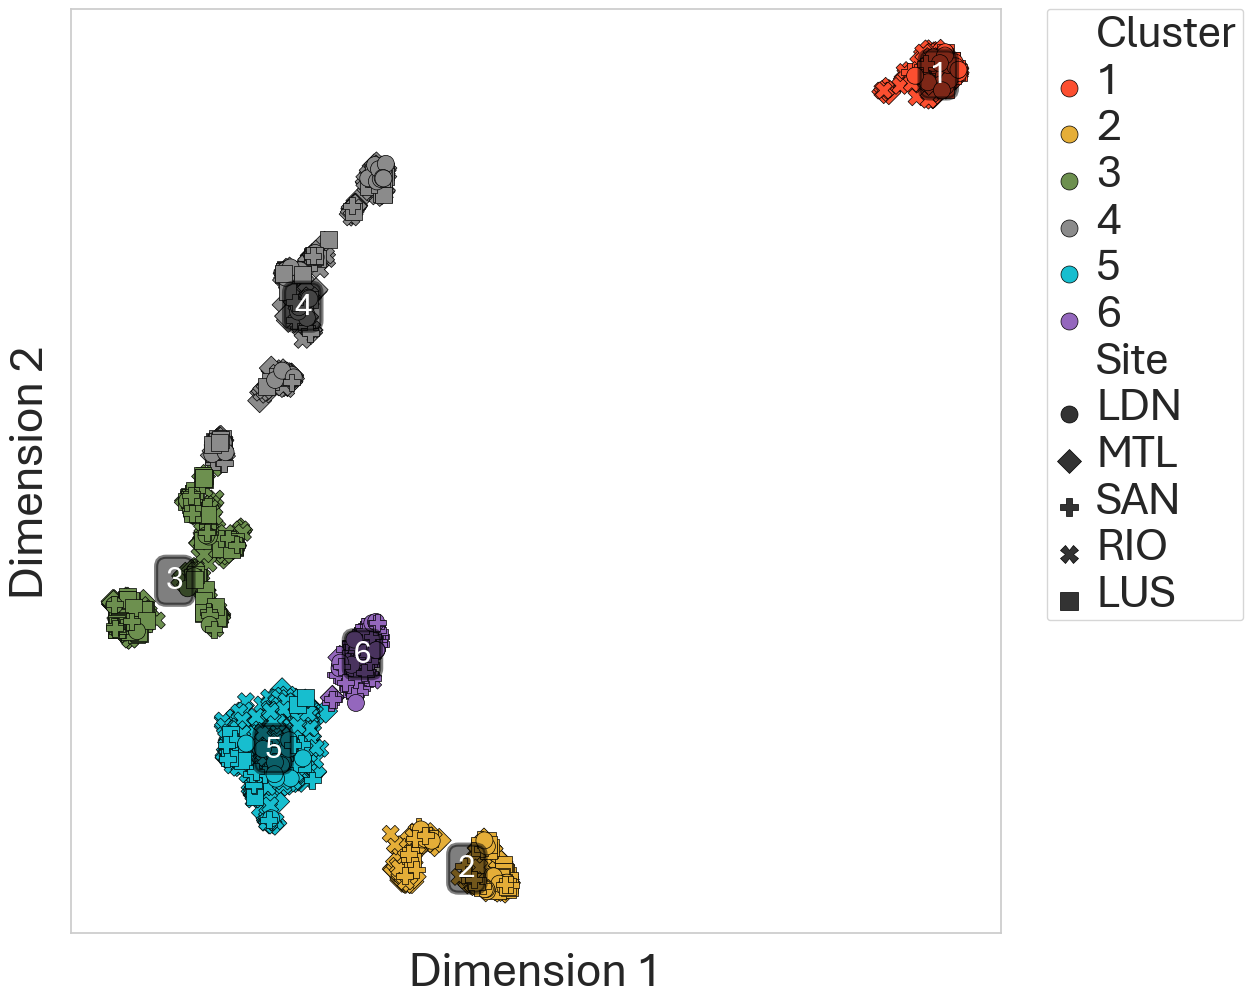

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = None, 
              centroids = True, 
              size_by_prob = False, 
              ax = ax,
              FONTSIZE = FONTSIZE*1.5,
              centroid_kws = {"alpha": 0.5, "palette_dict":None, "show_edge": False},)

# put legend inside frame
# plt.legend(title = "Site",  frameon = True, facecolor = "white", edgecolor = "black", shadow = False, fontsize = FONTSIZE, title_fontsize = FONTSIZE)

# save just this plot
plt.savefig(f"{figdir}/SYMPTOM-UMAP-HDBSCAN-{timestamp}.png", dpi = 600, bbox_inches = 'tight')


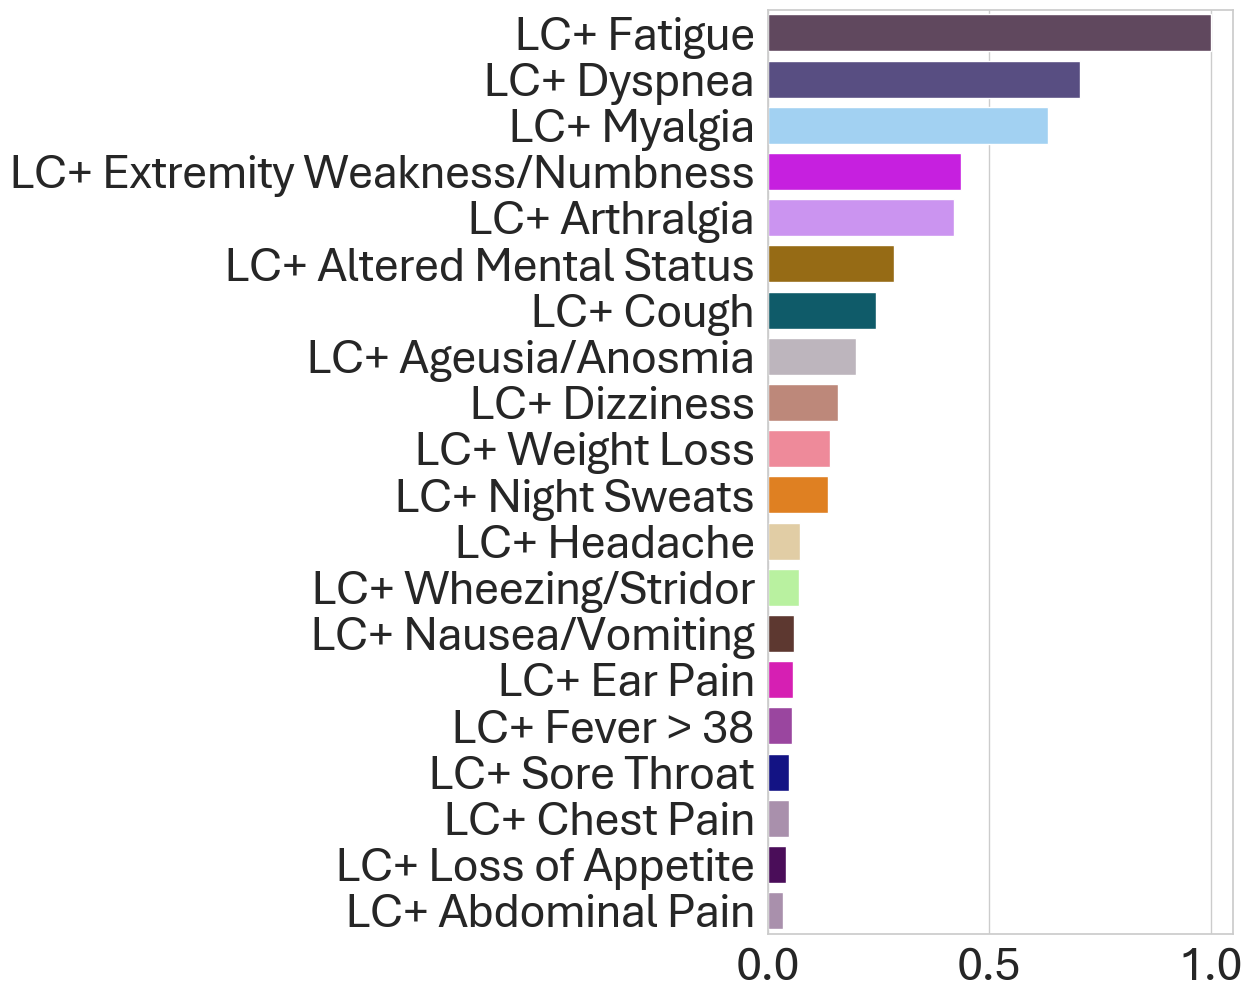

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(6,12))

plot_feature_importances(top_features, 
                         feature_map, 
                         feature_colour_map, 
                         ax,
                         FONTSIZE*1.5)
# @ save just this plot
plt.savefig(f"{figdir}/SYMPTOM-FI-{timestamp}.png", dpi = 600, bbox_inches = 'tight')


./OUTPUT/lc-pos-figures/2025-02-02/SYMPTOM-FPrev-6c-600dpi-2025-02-02.png
./OUTPUT/lc-pos-figures/2025-02-02/SYMPTOM-FPrev-6c-300dpi-2025-02-02.png


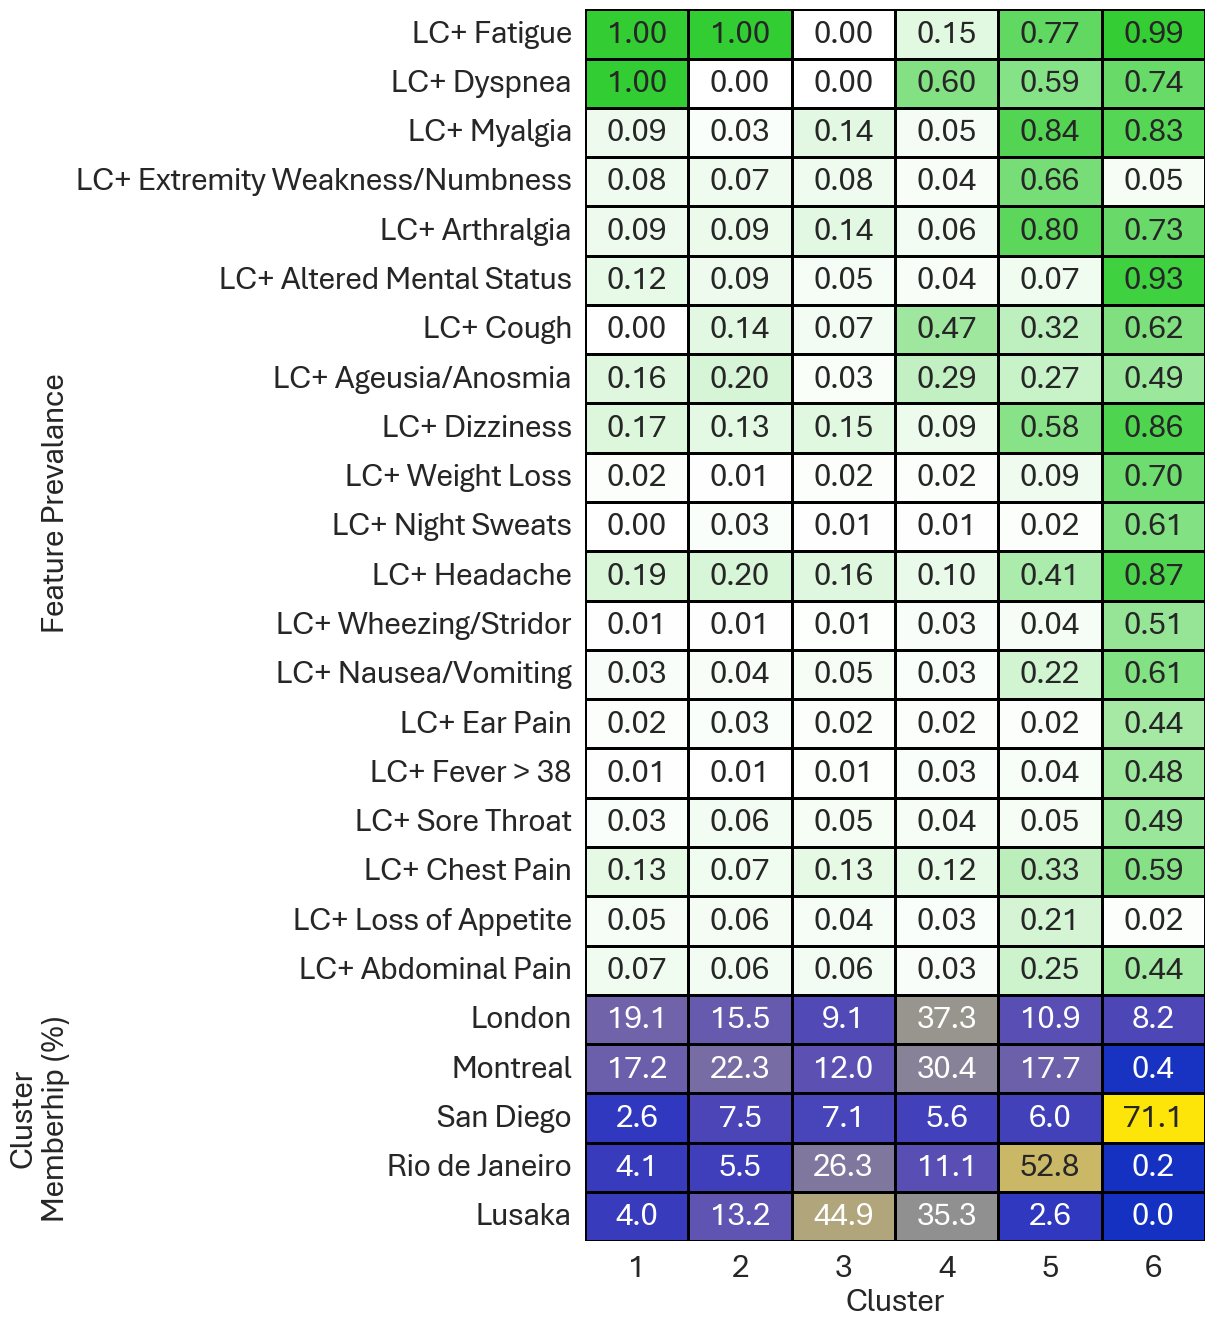

In [80]:
# heatmap of features by cluster
M = X.copy()
M = M[important_features]
M["cluster"] = [c+1 for c in cluster_labels]

# get the means
mfv = M.groupby("cluster").mean()

# sort the index by the order in fi_df
mfv = mfv[fi_df["Feature"]]

# transpose
mfv = mfv.T

# rename mfv index
mfv.index = mfv.index.map(feature_map)


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(8,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

# logscale the heatmap colour
# cmap = sns.color_palette("viridis", as_cmap = True)

# from matplotlib.colors import LogNorm

sns.heatmap(mfv[:20], 
            cmap = cmap, 
            # norm = LogNorm(),
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 24}
)

# turn off the xticks and x label
axs0.set_xticks([]); axs0.set_xlabel("")

sns.heatmap(cluster_membership_by_site,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            # norm = LogNorm(),
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 24}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

# output the figure

for dpi in [600, 300]:
    fn = f"{figdir}/SYMPTOM-FPrev-{n_clust}c-{dpi}dpi-{timestamp}.png"
    print(fn)
    plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')

# picle mfv
mfv.to_pickle(f"./SYMPTOM-only-feature-prevalence-by-cluster.pkl")


In [81]:
# for each cluster in mfv, find the features that are > 0.3

# make a dataframe to hold the results

# make a dictionary to hold the results
rd = {}

# iterate over the columns in mfv

for c in mfv.columns:
    
        # sort the values in the column
        srt = mfv[c].copy()
        srt.sort_values(ascending = False, inplace = True)

        # print(srt)

        srt_grt = srt[srt > 0.3]


        if len(srt_grt) == 0:
            # get the top 3 features instead
            srt_grt = srt.nlargest(3)


        print(srt_grt.values)

        # get the feature names
        features = srt_grt.index
        values = srt_grt.values
    
        # strip the "LC+" from the feature names
        features = [f.replace("LC+ ", "") for f in features]

        if len(features) > 3:
                features = features[:3]
                values = values[:3]

                # set the last feature to "Other (diffuse)"
                features[-1] = "Others (diffuse)"

                # get the mean value of the other features

                vm = srt_grt.values[3:].mean()
                print(vm)


                # vm = 1

                values[-1] = vm

        # add to the dictionary
        rd.update({c: (features, values)})

# make a dataframe from the dictionary
rd_df2 = pd.DataFrame.from_dict(rd, orient = "index")



[1.         0.99545455]
[1.]
[0.16083916 0.15151515 0.14452214]
[0.60483871 0.46975806]
[0.83612663 0.79515829 0.77281192 0.66108007 0.58659218 0.57914339
 0.40968343 0.33333333 0.31843575]
0.4813780260707636
[0.99014778 0.92610837 0.87192118 0.86206897 0.82758621 0.73891626
 0.73399015 0.7044335  0.62068966 0.60591133 0.60591133 0.591133
 0.51231527 0.49261084 0.48768473 0.48275862 0.44334975 0.43842365
 0.43349754 0.40394089]
0.5873659808751086


In [82]:
rd_df2.reset_index(inplace = True)
# rename the columns
rd_df2.columns = ["Cluster", "Feature", "Value"]
rd_df2

Cluster                                            Feature  \
0        1                                 [Dyspnea, Fatigue]   
1        2                                          [Fatigue]   
2        3                  [Headache, Dizziness, Arthralgia]   
3        4                                   [Dyspnea, Cough]   
4        5            [Myalgia, Arthralgia, Others (diffuse)]   
5        6  [Fatigue, Altered Mental Status, Others (diffu...   

                                               Value  
0                          [1.0, 0.9954545454545455]  
1                                              [1.0]  
2  [0.16083916083916083, 0.15151515151515152, 0.1...  
3          [0.6048387096774194, 0.46975806451612906]  
4  [0.8361266294227188, 0.7951582867783985, 0.481...  
5  [0.9901477832512315, 0.9261083743842364, 0.587...

In [83]:
# save rd_df2 to pickle
rd_df2.to_pickle(f"./SYMPTOM-only-rd_df2.pkl")

# TREEMAPS

In [84]:
# for each cluster in mfv, find the features that are > 0.3

rd = {}

# iterate over the columns in mfv

for c in mfv.columns:
    
        # sort the values in the column
        srt = mfv[c].copy()
        srt.sort_values(ascending = False, inplace = True)

        # find the features that are > 0.3
        srt_grt = srt[srt > 0.3]

        # print(srt_grt)

        # if they are all < 0.3, get the top 3
        if len(srt_grt) == 0:
            # get the top 3 features instead
            srt_grt = srt.nlargest(3)

        # get the feature names
        features = srt_grt.index
    
        # strip the "LC+" from the feature names
        features = [f.replace("LC+ ", "") for f in features]

        # if there are more than 3 features, keep only the top 3
        if len(features) > 3:
                features = features[:3]

                # set the last feature to "Other (diffuse)"
                features[-1] = "Others (diffuse)"

        # add to the dictionary
        rd.update({c: features})

# make a dataframe from the dictionary
rd_df = pd.DataFrame.from_dict(rd, orient = "index")



In [85]:
# summarize cbs by total number of records per cluster
cbs2 = cbs.sum(axis = 0)/cbs.sum().sum()*100

cbs2 = pd.DataFrame(cbs2, columns = ["Fraction"])

# reset the index
cbs2.reset_index(inplace = True)


In [86]:
s1 = rd_df[0].to_list()
s2 = rd_df[1].to_list()
s3 = rd_df[2].to_list()

cbs2["s1"] = pd.Series(s1)
cbs2["s2"] = pd.Series(s2)
cbs2["s3"] = pd.Series(s3)

In [87]:
# add a column to cbs2 that counts the number of symptoms
cbs2["n"] = cbs2["s1"].apply(lambda x: 1 if x != None else 0) + cbs2["s2"].apply(lambda x: 1 if x != None else 0) + cbs2["s3"].apply(lambda x: 1 if x != None else 0)

# round fraction to 1 decimal place
cbs2["Fraction"] = cbs2["Fraction"].round(1)

In [88]:
cbs2["colour"] = [cc.glasbey_dark[i] for i in cbs2["n"]]

# change the value of colour if s3 contains diffuse
idx = cbs2.loc[cbs2["s3"] == "Others (diffuse)"] 

cbs2.loc[idx.index, "colour"] = "#dedbef"


for i, row in cbs2.iterrows():

    # label elements
    l1 = row["s1"]
    if row["s2"] == None:
        l2 = ""
    else:
        l2 = row["s2"]

    if row["s3"] == None:
        l3 = ""
    else:   
        l3 = row["s3"]

    lbl = f"Cluster {i+1}:\n{row['Fraction']:0.1f}%\n{l1}"
    if l2 != "":
        lbl += f"\n{l2}"
    if l3 != "":
        lbl += f"\n{l3}"

    cbs2.loc[i, "label"] = lbl



In [89]:
# get the set of unique feature names in rd_df2["Features"]
features = set()

for i, row in rd_df2.iterrows():
    for f in row["Feature"]:
        features.add(f)

# make a dictionary to hold the results

features

{'Altered Mental Status',
 'Arthralgia',
 'Cough',
 'Dizziness',
 'Dyspnea',
 'Fatigue',
 'Headache',
 'Myalgia',
 'Others (diffuse)'}

In [90]:
data = []

rd_df2["Fraction"] = cbs2["Fraction"]

for i, row in rd_df2.iterrows():

    # print (i,row)

    cluster = row["Cluster"]
    features = row["Feature"]
    values = row["Value"]

    print(cluster, features, values)

    the_dict = {"id": f"Cluster {cluster}",
                "datum": row["Fraction"],
                }

    the_children = []

    for id,datum in zip(features, values):
            
            the_children.append({"id": id,
                                 "datum": datum,
                                })

    the_dict["children"] = the_children
    data.append(the_dict)
data

1 ['Dyspnea', 'Fatigue'] [1.         0.99545455]
2 ['Fatigue'] [1.]
3 ['Headache', 'Dizziness', 'Arthralgia'] [0.16083916 0.15151515 0.14452214]
4 ['Dyspnea', 'Cough'] [0.60483871 0.46975806]
5 ['Myalgia', 'Arthralgia', 'Others (diffuse)'] [0.83612663 0.79515829 0.48137803]
6 ['Fatigue', 'Altered Mental Status', 'Others (diffuse)'] [0.99014778 0.92610837 0.58736598]


[{'id': 'Cluster 1',
  'datum': 10.0,
  'children': [{'id': 'Dyspnea', 'datum': 1.0},
   {'id': 'Fatigue', 'datum': 0.9954545454545455}]},
 {'id': 'Cluster 2',
  'datum': 14.1,
  'children': [{'id': 'Fatigue', 'datum': 1.0}]},
 {'id': 'Cluster 3',
  'datum': 19.6,
  'children': [{'id': 'Headache', 'datum': 0.16083916083916083},
   {'id': 'Dizziness', 'datum': 0.15151515151515152},
   {'id': 'Arthralgia', 'datum': 0.1445221445221445}]},
 {'id': 'Cluster 4',
  'datum': 22.6,
  'children': [{'id': 'Dyspnea', 'datum': 0.6048387096774194},
   {'id': 'Cough', 'datum': 0.46975806451612906}]},
 {'id': 'Cluster 5',
  'datum': 24.5,
  'children': [{'id': 'Myalgia', 'datum': 0.8361266294227188},
   {'id': 'Arthralgia', 'datum': 0.7951582867783985},
   {'id': 'Others (diffuse)', 'datum': 0.4813780260707636}]},
 {'id': 'Cluster 6',
  'datum': 9.3,
  'children': [{'id': 'Fatigue', 'datum': 0.9901477832512315},
   {'id': 'Altered Mental Status', 'datum': 0.9261083743842364},
   {'id': 'Others (diffus

In [91]:
fc2 = {'Dyspnea': [0.32549, 0.270588, 0.545098],
       'Arthralgia': [0.807843, 0.521569, 1.0],
       'Cough': [0.0, 0.4, 0.470588],
       'Fatigue': [0.392157, 0.266667, 0.380392],
       'Dizziness': [0.784314, 0.509804, 0.435294],
       'Headache': [0.921569, 0.815686, 0.607843],
       'Myalgia': [0.584314, 0.827451, 1.0],
       'Altered Mental Status': [0.670588, 0.447059, 0.0],
       'Others (diffuse)': [0.8, 0.8, 0.8],}

In [92]:
# select only keys that start with LC+
feature_colour_map = {k: v for k, v in feature_colour_map.items() if k.startswith("LC+")}

In [93]:

import circlify
circles = circlify.circlify(data, show_enclosure=False)


Cluster 6
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5
Others (diffuse)
Altered Mental Status
Fatigue
Fatigue
Dyspnea
Others (diffuse)
Arthralgia
Dizziness
Headache
Cough
Arthralgia
Myalgia
Dyspnea
Fatigue
./OUTPUT/lc-pos-figures/2025-02-02/SYMPTOM-TREEMAP-coloured-by-cluster-6c-300dpi-2025-02-02.png
./OUTPUT/lc-pos-figures/2025-02-02/SYMPTOM-TREEMAP-coloured-by-cluster-6c-600dpi-2025-02-02.png


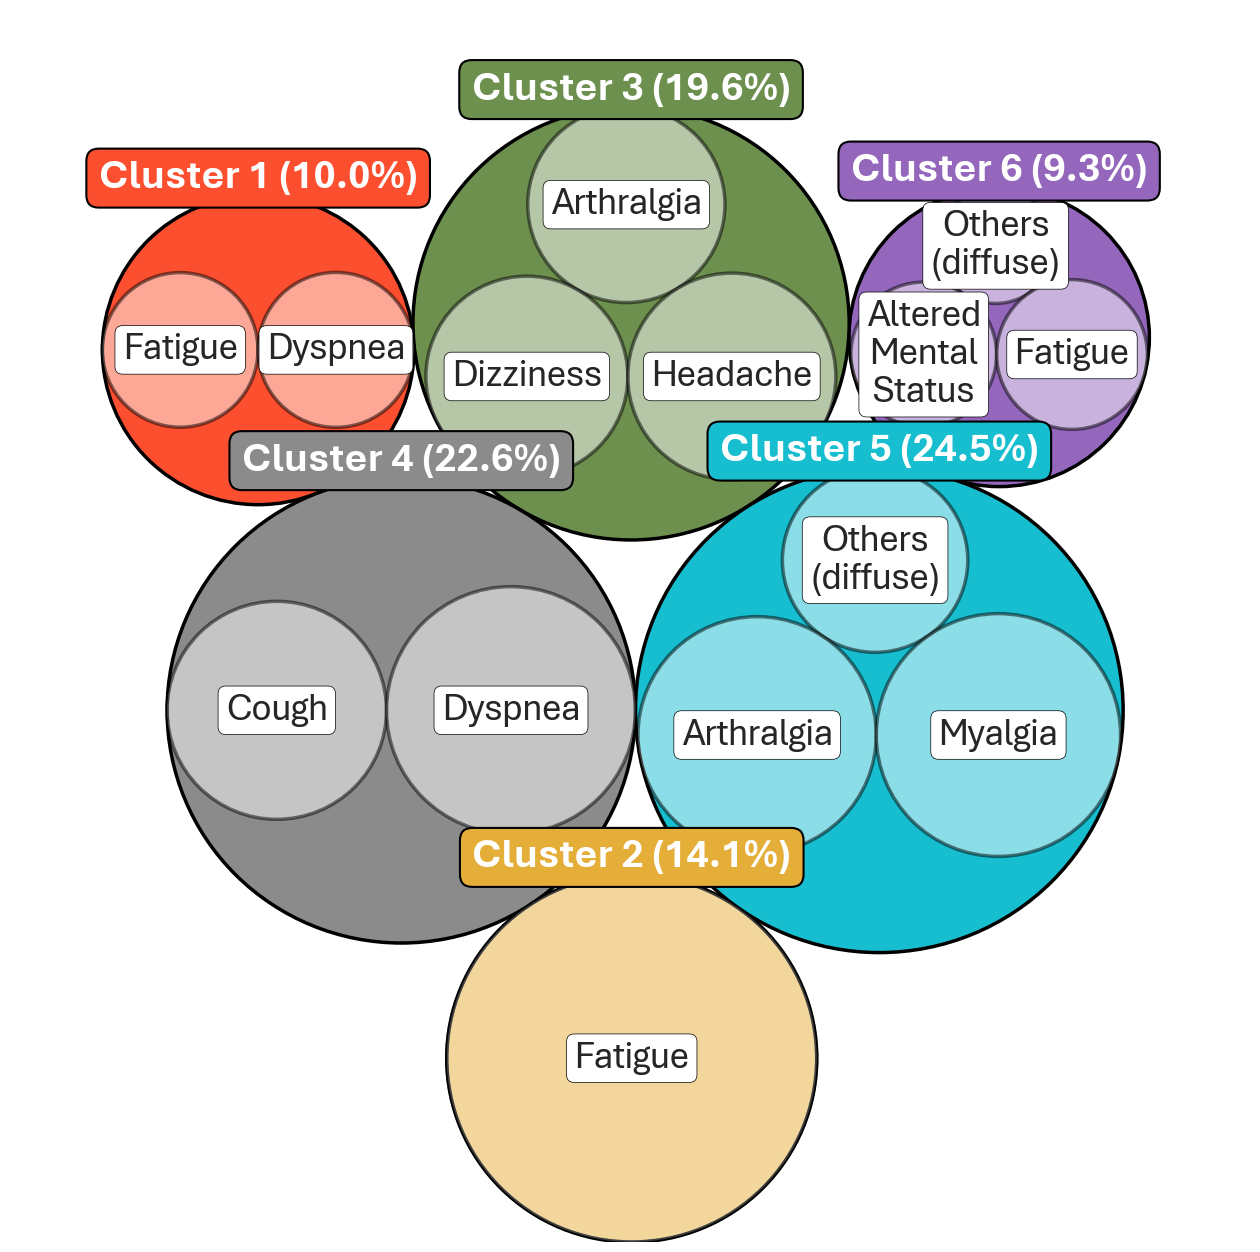

In [120]:

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(16, 16))

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

COLOUR_FEATURES = False

if COLOUR_FEATURES:
    node_alpha  = 0.75
    child_alpha = 1.0
else:
    node_alpha   = 1.0
    child_alpha  = 0.5
    child_colour = "white"

# print circles
for i, circle in enumerate(circles):

    x, y, r = circle
    
    print(circle.ex["id"])
    
    if circle.level == 0:
        pass
    if circle.level == 1:
        idx = circle.ex["id"].split(" ")[1]
        the_color = cc.glasbey_hv[int(idx)]
        the_alpha = node_alpha
        font_size = 24
        font_weight = "bold"

        bbox_dict = dict(
                    facecolor=the_color,
                    edgecolor='black', 
                    boxstyle='round', 
                    pad=0.3,
                    linewidth = 1.5)

    if circle.level == 2:

        if COLOUR_FEATURES:
            if circle.ex["id"] in fc2.keys():
                print(f"FOUND {circle.ex['id']} in fc2.keys()")
                # child_color = fc2[circle.ex["id"]]
                the_color = fc2[circle.ex["id"]]
            else:
                the_color = "grey"
        else:
            the_color = child_colour

        the_alpha = child_alpha
        font_size = 24
        font_weight = "normal"

        bbox_dict = dict(
                        facecolor="white", 
                        edgecolor='black', 
                        boxstyle='round', 
                        pad=.2, 
                        alpha = 1.0, 
                        linewidth = 0.5, 
                        )

    # draw the circle
    ax.add_patch(plt.Circle(
                            (x, y), 
                            r, 
                            facecolor = the_color, 
                            alpha     = the_alpha,
                            fill      = True, 
                            ec        = "black",
                            lw        = 2.5,
                            )
                        )

    # add the labels
    if circle.level == 1:

        lbl1 = f"{circle.ex['id']} ({circle.ex['datum']}%)"

        ax.text(x, y+(r*1.0),
                lbl1, 
                ha='center', 
                va='bottom', 
                fontsize=30,
                color = "white", 
                fontweight = font_weight,
                bbox=bbox_dict)    

    # child circles
    if circle.level == 2:

        lbl = circle.ex["id"]
        wt  = circle.ex["datum"]

        # if there is a /, split and bnewling
        if "/" in lbl:
            lbl = lbl.split("/")[0] + "/\n" + lbl.split("/")[1]

        # split on spaces and replace with newlines
        lbl = lbl.replace(" ", "\n")
        ax.text(x, y, lbl,
                    ha='center', 
                    va='center', 
                    bbox     = bbox_dict,
                    fontsize = 28,
        )


for dpi in [300,600]:

    if COLOUR_FEATURES:
        tag = "coloured-by-feature"
    else:
        tag = "coloured-by-cluster"

    fn = f"{figdir}/SYMPTOM-TREEMAP-{tag}-{n_clust}c-{dpi}dpi-{timestamp}.png"
    print(fn)

    plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')


plt.show()

In [121]:
# save cbs2 as a pickle
cbs2.to_pickle(f"./SYMPTOM-only-TREEMAP-{n_clust}.pkl")

### igraph

In [122]:
import pandas as pd
n_clust = 6


# load the pickle
cbs2 = pd.read_pickle(f"./SYMPTOM-only-TREEMAP-{n_clust}.pkl")
rd_df2 = pd.read_pickle("./SYMPTOM-only-rd_df2.pkl")

In [123]:
# import python igraph
import igraph as ig


In [124]:
# Make a list of tuples that joins the cluster number with the symptom
ee = []
wts = []

for i, row in rd_df2.iterrows():

    cluster = row["Cluster"]
    features = row["Feature"]
    values = row["Value"]

    print(cluster, features, values)

    for f,v in zip(features, values):
        ee.append((f, f"Cluster {cluster}"))
        wts.append(v)

ee, wts

1 ['Dyspnea', 'Fatigue'] [1.         0.99545455]
2 ['Fatigue'] [1.]
3 ['Headache', 'Dizziness', 'Arthralgia'] [0.16083916 0.15151515 0.14452214]
4 ['Dyspnea', 'Cough'] [0.60483871 0.46975806]
5 ['Myalgia', 'Arthralgia', 'Others (diffuse)'] [0.83612663 0.79515829 0.48137803]
6 ['Fatigue', 'Altered Mental Status', 'Others (diffuse)'] [0.99014778 0.92610837 0.58736598]


([('Dyspnea', 'Cluster 1'),
  ('Fatigue', 'Cluster 1'),
  ('Fatigue', 'Cluster 2'),
  ('Headache', 'Cluster 3'),
  ('Dizziness', 'Cluster 3'),
  ('Arthralgia', 'Cluster 3'),
  ('Dyspnea', 'Cluster 4'),
  ('Cough', 'Cluster 4'),
  ('Myalgia', 'Cluster 5'),
  ('Arthralgia', 'Cluster 5'),
  ('Others (diffuse)', 'Cluster 5'),
  ('Fatigue', 'Cluster 6'),
  ('Altered Mental Status', 'Cluster 6'),
  ('Others (diffuse)', 'Cluster 6')],
 [1.0,
  0.9954545454545455,
  1.0,
  0.16083916083916083,
  0.15151515151515152,
  0.1445221445221445,
  0.6048387096774194,
  0.46975806451612906,
  0.8361266294227188,
  0.7951582867783985,
  0.4813780260707636,
  0.9901477832512315,
  0.9261083743842364,
  0.5873659808751086])

In [125]:
g = ig.Graph( directed = True)

src = list(set([e[0] for e in ee]))
tgt = list(set([e[1] for e in ee]))

g.add_vertices(src)
g.add_vertices(tgt)

g.add_edges(ee)

ig.summary(g)

IGRAPH DN-- 15 14 -- 
+ attr: name (v)


In [126]:

# assign name attribute
g.vs["name"] = src + tgt
g.vs["color"] = ["white" if v in src else "grey" for v in g.vs["name"]]

g.vs["size"] = [100 if v in src else 20 for v in g.vs["name"]]

# enumerate the src vertices
src_idx = [g.vs.find(name = s).index for s in src]
tgt_idx = [g.vs.find(name = t).index for t in tgt]
# g.vs[tgt_idx]["name"] = [i+i for i in range(len(tgt))]
# change the colours of the source vertices using the index list

import colorcet as cc
from math import log10

# g.vs[tgt_idx]["color"] = [cc.glasbey_hv[i+1] for i in range(len(tgt))]

clr = []
for i, t in enumerate(tgt):
    the_tgt_idx = t.split(" ")[1]
    clr.append(cc.glasbey_hv[int(the_tgt_idx)])
g.vs[tgt_idx]["color"] = clr

g.vs[tgt_idx]["size"] = [log10(cbs2.loc[i, "Fraction"])*50 for i in range(len(tgt))]
# make a new empty layout object
layout = ig.Layout()

# for each vertex in the graph, assign a position
for i, v in enumerate(g.vs):

    if v["name"] in src:
       layout.append((0, i*120))


# for the target vertices, assign a position
# get the target vertices
tv = [v for v in g.vs if v["name"] not in src]

for i, v in enumerate(tv):
    layout.append((1, i*120))


# # tgt vertex label to the right
# g.vs[tgt_idx]["label_dist"] = 2
# g.vs[tgt_idx]["label_angle"] = 0

# # src vertex label to the left
# g.vs[src_idx]["label_dist"] = 2
# g.vs[src_idx]["label_angle"] = 3.14

# edge weights
g.es["width"] = [w*10 for w in wts]


# make the edge color equal to the target vertex color
g.es["color"] = [g.vs[e.target]["color"] for e in g.es]

In [127]:
# ig.plot(g,
#         bbox = (1200, 1200),
#         margin = 200,
#         # vertex_size = 40,
#         vertex_label = g.vs["name"],
#         # layout = layout,
#         layout = 'circular',
#         autocurve = True,

#         edge_width = g.es["width"],

#         # make arrowhead wider
#         edge_arrow_size = 2.5,


#         # offset the vertex label to the right

#         # vertex_label_dist = 1.5,
#         # vertex_label_angle = 0,

#         # curve edges
#         # edge_curved = 0.3,
# )

### for LaTeX

In [128]:
# make an output dir for tex files
from pathlib import Path
texpath = Path("./tex-figures")

if not texpath.exists():
    texpath.mkdir()


In [129]:
# load the sites symptoms pickle
mfv = pd.read_pickle(f"./sites-symptoms.pkl")

In [130]:
fc2 = {'Dyspnea': [0.32549, 0.270588, 0.545098],
       'Arthralgia': [0.807843, 0.521569, 1.0],
       'Cough': [0.0, 0.4, 0.470588],
       'Fatigue': [0.392157, 0.266667, 0.380392],
       'Dizziness': [0.784314, 0.509804, 0.435294],
       'Headache': [0.921569, 0.815686, 0.607843],
       'Myalgia': [0.584314, 0.827451, 1.0],
       'Altered Mental Status': [0.670588, 0.447059, 0.0],
       'Others (diffuse)': [0.8, 0.8, 0.8],}

In [131]:
# get the set of unique feature names in rd_df2["Features"]
features = set()

for i, row in rd_df2.iterrows():
    for f in row["Feature"]:
        features.add(f)

features

{'Altered Mental Status',
 'Arthralgia',
 'Cough',
 'Dizziness',
 'Dyspnea',
 'Fatigue',
 'Headache',
 'Myalgia',
 'Others (diffuse)'}

In [132]:
rd_df2["Fraction"] = cbs2["Fraction"]

In [133]:
import matplotlib.colors as mcolors
import colorcet as cc

### Nodes

In [134]:
# NODES - Clusters
cluster_data = pd.DataFrame()

cluster_data["Cluster"] = rd_df2["Cluster"]

# fraction should be converted to the start and stop positions coveriung 180 degrees
cluster_data["start"] = 0
cluster_data["stop"] = 0

# iterate over the clusters

for i, row in rd_df2.iterrows():
    
        # get the cluster number
        cluster = row["Cluster"]

        # get the fraction
        frac = row["Fraction"]

        if i == 0:
            start = 0
            stop = frac
        else:
            start = stop
            stop = start + frac

        cluster_data.loc[i, "start"] = int(start*180/100)
        cluster_data.loc[i, "stop"] = int(stop*180/100)
        cluster_data.loc[i, "mid"] = ((start + stop)/2)*180/100
        # convert HTML colour to RGB
        c = mcolors.to_rgb(cbs2.loc[i, "colour"])
        c = [int(255*x) for x in c]
        cluster_data.loc[i, "COLOUR"] = f"clustercolour{cluster}"
        cluster_data.loc[i, "NW"] = round(frac*180/100)

# rename the columns
cluster_data.columns = ["LABEL", "START", "END", "MID", "COLOUR","NW"]

# resequence the columns
cluster_data = cluster_data[["START", "END", "MID", "NW","COLOUR", "LABEL"]]

# prepend text to the label
cluster_data["NODENAME"] = cluster_data["LABEL"].apply(lambda x: f"c{x}")
cluster_data["LABEL"] = cluster_data["LABEL"].apply(lambda x: f"Cluster {x}")

cluster_data

START  END     MID    NW          COLOUR      LABEL NODENAME
0      0   18    9.00  18.0  clustercolour1  Cluster 1       c1
1     18   43   30.69  25.0  clustercolour2  Cluster 2       c2
2     43   78   61.02  35.0  clustercolour3  Cluster 3       c3
3     78  119   99.00  41.0  clustercolour4  Cluster 4       c4
4    119  163  141.39  44.0  clustercolour5  Cluster 5       c5
5    163  180  171.81  17.0  clustercolour6  Cluster 6       c6

In [135]:
# NODES - Symptoms

features_data = pd.DataFrame()

# how many features?
n_features = len(features)

# sort the features
features = sorted(features)


features_data["LABEL"] = [f for f in features]
for i in range(n_features):
    start = 180/n_features*i + 180
    end  = 180/n_features*(i+1) + 180

    features_data.loc[i, "START"] = start
    features_data.loc[i, "END"] = end
    features_data.loc[i, "MID"] = (start + end)/2

    features_data.loc[i, "NW"] = 180/n_features

    # features_data.loc[i, "COLOUR"] = "gray"
    features_data.loc[i, "COLOUR"] = f"featurecolour{i+1}"

    features_data.loc[i,"NODENAME"] = f"f{i+1}"


    # add a coloumn for textcolour, based on the luminance of the COLOUR
    # get the RGB values
    c = mcolors.to_rgb(cc.glasbey_hv[i+1])

    # get the luminance
    lum = 0.2126*c[0] + 0.7152*c[1] + 0.0722*c[2]
    print(features_data.loc[i, "LABEL"],c,lum)


    # if the luminance is less than 0.5, use white, otherwise use black
    if lum > 0.4:
        features_data.loc[i, "TEXTCOLOUR"] = "white"
    else:
        features_data.loc[i, "TEXTCOLOUR"] = "black"

# TODO:
# get teh text colours right!

# resequence
features_data = features_data[["START", "END", "MID", "NW", "COLOUR","LABEL","NODENAME","TEXTCOLOUR"]]


Altered Mental Status (0.988235, 0.309804, 0.188235) 0.4452611488
Arthralgia (0.898039, 0.682353, 0.219608) 0.6947976546
Cough (0.427451, 0.564706, 0.309804) 0.5171216626
Dizziness (0.545098, 0.545098, 0.545098) 0.545098
Dyspnea (0.090196, 0.745098, 0.811765) 0.6106791921999999
Fatigue (0.580392, 0.403922, 0.741176) 0.4657892608
Headache (0.839216, 0.152941, 0.156863) 0.2991262334
Myalgia (0.121569, 0.466667, 0.705882) 0.4105704882
Others (diffuse) (0.890196, 0.466667, 0.760784) 0.5779445128


In [136]:
# save colours and nodes

# write colours as TEX file

# write out the SYMPTOM colours 
with open(texpath / "colours-features.tex", "w") as f:

    for i,row in features_data.iterrows():
        c = fc2[row["LABEL"]]
        f.write(f"\\definecolor{{featurecolour{i+1}}}{{RGB}}{{{c[0]*255}, {c[1]*255}, {c[2]*255}}}\n")

f.close()

# CLUSTER colours
with open(texpath / "colours-clusters.tex", "w") as f:

    for i,row in cluster_data.iterrows():
        c = cc.glasbey_hv[i+1]
        f.write(f"\\definecolor{{clustercolour{i+1}}}{{RGB}}{{{c[0]*255}, {c[1]*255}, {c[2]*255}}}\n")

f.close()


# save each set of nodes as csv
cluster_data.to_csv(texpath / "nodes-cluster.csv", index = False)
features_data.to_csv(texpath / "nodes-symptom.csv", index = False)

# stack with the tikz_data dataframe
tikz_data = pd.concat([cluster_data, features_data], axis = 0)
# tikz_data.to_csv(texpath / "nodes-cluster-x-symptoms.csv", index = False)

In [137]:
# NODES - Sites

site_nodes = pd.DataFrame()

for i in range(len(site_name_dict)):
    site_nodes.loc[i, "LABEL"] = list(site_name_dict.values())[i]
    # site_nodes.loc[i, "COLOUR"] = list(site_style_dict.values())[i]

    start = 180/len(site_name_dict)*i
    end = 180/len(site_name_dict)*(i+1)
    mid = (start + end)/2

    site_nodes.loc[i, "START"] = start
    site_nodes.loc[i, "END"] = end
    site_nodes.loc[i, "MID"] = mid
    site_nodes.loc[i, "MIDALT"] = mid+180
    site_nodes.loc[i, "STARTALT"] = start+180
    site_nodes.loc[i, "ENDALT"] = end+180

    site_nodes.loc[i, "NW"] = 180/len(site_name_dict)

    site_nodes.loc[i, "NODENAME"] = f"site{i+1}"
    site_nodes.loc[i, "SITE"] = f"{i+1}"



# resequence
site_nodes = site_nodes[["START", "END", "MID", "NW", "LABEL","NODENAME","SITE","MIDALT","STARTALT", "ENDALT"]]

site_nodes.to_csv(texpath / "nodes-sites.csv", index = False)
site_nodes


START    END    MID    NW LABEL NODENAME SITE  MIDALT  STARTALT  ENDALT
0    0.0   36.0   18.0  36.0   LDN    site1    1   198.0     180.0   216.0
1   36.0   72.0   54.0  36.0   MTL    site2    2   234.0     216.0   252.0
2   72.0  108.0   90.0  36.0   SAN    site3    3   270.0     252.0   288.0
3  108.0  144.0  126.0  36.0   RIO    site4    4   306.0     288.0   324.0
4  144.0  180.0  162.0  36.0   LUS    site5    5   342.0     324.0   360.0

In [138]:
# count the sites


s2 = sites.value_counts()/sites.value_counts().sum()*100

# add the s2 fractions to the site_nodes dataframe, matching on the site label
site_nodes["FRACTION"] = 0

for i, row in site_nodes.iterrows():

    site = row["LABEL"]
    print(site)
    frac = s2.loc[site]
    site_nodes.loc[i, "FRACTION"] = round(frac,1)
    site_nodes.loc[i, "NW2"] = site_nodes.loc[i, "FRACTION"]*180/100

    # start, stop, mid
    if i == 0:
        site_nodes.loc[i, "START2"] = 0
        site_nodes.loc[i, "END2"] = site_nodes.loc[i, "FRACTION"]*180/100
    else:
        site_nodes.loc[i, "START2"] = site_nodes.loc[i-1, "END2"]
        site_nodes.loc[i, "END2"] = site_nodes.loc[i, "START2"] + site_nodes.loc[i, "NW2"]


    site_nodes.loc[i, "MID2"] = (site_nodes.loc[i, "START2"] + site_nodes.loc[i, "END2"])/2

site_nodes.to_csv(texpath / "nodes-sites.csv", index = False)
site_nodes

LDN
MTL
SAN
RIO
LUS


START    END    MID    NW LABEL NODENAME SITE  MIDALT  STARTALT  ENDALT  \
0    0.0   36.0   18.0  36.0   LDN    site1    1   198.0     180.0   216.0   
1   36.0   72.0   54.0  36.0   MTL    site2    2   234.0     216.0   252.0   
2   72.0  108.0   90.0  36.0   SAN    site3    3   270.0     252.0   288.0   
3  108.0  144.0  126.0  36.0   RIO    site4    4   306.0     288.0   324.0   
4  144.0  180.0  162.0  36.0   LUS    site5    5   342.0     324.0   360.0   

   FRACTION    NW2  START2    END2    MID2  
0       5.0   9.00    0.00    9.00    4.50  
1      40.8  73.44    9.00   82.44   45.72  
2      12.1  21.78   82.44  104.22   93.33  
3      29.7  53.46  104.22  157.68  130.95  
4      12.4  22.32  157.68  180.00  168.84

### Edges

In [139]:
# EDGES - CLUSTERS to SYMPTOMS

edges_df = pd.DataFrame()
edge_dict = {}

edges_list = []

# use the edges calculated above in igraph section
for edge, weight in zip(ee, wts):
    t = edge[0]
    s = edge[1]

    # print(edge)

    w = weight

    # look up the mid points
    mids = tikz_data.loc[tikz_data['LABEL'] == s]["MID"].values[0]
    midt = tikz_data.loc[tikz_data['LABEL'] == t]["MID"].values[0]

    # look up the node names for source and target
    ns = tikz_data.loc[tikz_data['LABEL'] == s]["NODENAME"].values[0]
    nt = tikz_data.loc[tikz_data['LABEL'] == t]["NODENAME"].values[0]
    
    # print(ns,nt)

    # look up the colour of the source node
    c = tikz_data.loc[tikz_data['LABEL'] == t]["COLOUR"].values[0]
    # print(c)

    # print(midt, mids, midt - mids, w)

    if midt - mids > 120:
        side = "right"
    else:
        side = "left"

    # # determine the direction of the bend
    # if mids > 270.00:
    #     side = "left"
    # else:
    #     side = "right"
    
    edge_string = f"({ns}) to [bend {side}=45] ({nt})"

    # print(edge_string)

    dd = (ns, nt, max(int(w*10),5), edge_string,c)

    edges_list.append(dd)

# make a dataframe from the list of tuples
edges_df = pd.DataFrame(edges_list, columns = ["NODESTART", "NODEEND","WIDTH","EDGESTRING","EDGECOLOUR"])

# select

# save edges_df as csv, without index
edges_df.to_csv(texpath / "edges-cluster-x-symptoms.csv", index = False)
print(edges_df)

# for ther ternary diagram, all edges should bend left
# take edges_df and change the bend direction to left
edges_df["EDGESTRING"] = edges_df["EDGESTRING"].apply(lambda x: x.replace("left", "right"))
edges_df["EDGESTRING"] = edges_df["EDGESTRING"].apply(lambda x: x.replace("25", "60"))

# output
edges_df.to_csv(texpath / "edges-cluster-x-symptoms-ternary.csv", index = False)

   NODESTART NODEEND  WIDTH                    EDGESTRING      EDGECOLOUR
0         c1      f5     10  (c1) to [bend right=45] (f5)  featurecolour5
1         c1      f6      9  (c1) to [bend right=45] (f6)  featurecolour6
2         c2      f6     10  (c2) to [bend right=45] (f6)  featurecolour6
3         c3      f7      5  (c3) to [bend right=45] (f7)  featurecolour7
4         c3      f4      5  (c3) to [bend right=45] (f4)  featurecolour4
5         c3      f2      5  (c3) to [bend right=45] (f2)  featurecolour2
6         c4      f5      6  (c4) to [bend right=45] (f5)  featurecolour5
7         c4      f3      5  (c4) to [bend right=45] (f3)  featurecolour3
8         c5      f8      8  (c5) to [bend right=45] (f8)  featurecolour8
9         c5      f2      7   (c5) to [bend left=45] (f2)  featurecolour2
10        c5      f9      5  (c5) to [bend right=45] (f9)  featurecolour9
11        c6      f6      9   (c6) to [bend left=45] (f6)  featurecolour6
12        c6      f1      9   (c6) to 

In [140]:
# EDGES - SITES to SYMPTOMS

# sort the cols
mfv = mfv[sorted(mfv.columns)]

# name mapping
site_map = {1:'LDN',
            2:'MTL',
            3:'SAN',
            4:'RIO',
            5:'LUS',}

# reverse the site_map
site_map = {v:k for k,v in site_map.items()}

# add a column for other (diffuse)

mfv["Others (diffuse)"] = 0.05

edges_list = []

idx = 1

for i, row in mfv.iterrows():

    idx = site_map[i]

    ns = f"site{idx}"
    for j, v in enumerate(mfv.columns):
        # print(j+1,v)

        nt = f"f{j+1}"
        w = row[j]

        # TODO: calcualte side

        # look up the mid points
        mids = site_nodes.loc[site_nodes['SITE'] == str(idx)]["MID"].values[0]
        midt = features_data.loc[features_data['LABEL'] == v]["MID"].values[0]

        # print(midt, mids, midt - mids)

        # look up the colour of the target node
        c = features_data.loc[features_data['LABEL'] == v]["COLOUR"].values[0]


        if midt - mids > 120:
            side = "right"
        else:
            side = "left"

        # print(ns,nt)

        if w > 0.3:

            edge_string = f"({ns}) to [bend {side}=25] ({nt})"
            # edges_list.append(( ns, nt, 3,edge_string))
            edges_list.append(( ns, nt, int(w*10),edge_string,c))
        else:
            pass

        # for  lusak, the weights are quite low
        if idx == 5:
            if w > 0.13:
                edge_string = f"({ns}) to [bend {side}=25] ({nt})"
                # edges_list.append(( ns, nt, 3,edge_string))
                edges_list.append(( ns, nt, int(w*10),edge_string,c))
                print(ns, nt, w, edge_string)
            else:
                pass
        
        if v == "Others (diffuse)":
            edge_string = f"({ns}) to [bend {side}=25] ({nt})"
            # edges_list.append(( ns, nt, 3,edge_string))
            edges_list.append(( ns, nt, 1,edge_string,c))
            print(ns, nt, w, edge_string)


    idx += 1


# # make a dataframe from the list of tuples
edges_df = pd.DataFrame(edges_list, columns = ["NODESTART", "NODEEND","WIDTH", "EDGESTRING","EDGECOLOUR"])

# save df
edges_df.to_csv(texpath / "edges-sites-x-symptoms.csv", index = False)

print(edges_df)


# for ther ternary diagram, all edges should bend left
# take edges_df and change the bend direction to left
edges_df["EDGESTRING"] = edges_df["EDGESTRING"].apply(lambda x: x.replace("right", "left"))
edges_df["EDGESTRING"] = edges_df["EDGESTRING"].apply(lambda x: x.replace("25", "60"))

edges_df.to_csv(texpath / "edges-sites-x-symptoms-ternary.csv", index = False)

site1 f9 0.05 (site1) to [bend right=25] (f9)
site5 f3 0.2977941176470588 (site5) to [bend left=25] (f3)
site5 f5 0.23161764705882354 (site5) to [bend left=25] (f5)
site5 f6 0.20220588235294118 (site5) to [bend right=25] (f6)
site5 f9 0.05 (site5) to [bend right=25] (f9)
site2 f9 0.05 (site2) to [bend right=25] (f9)
site4 f9 0.05 (site4) to [bend right=25] (f9)
site3 f9 0.05 (site3) to [bend right=25] (f9)
   NODESTART NODEEND  WIDTH                       EDGESTRING      EDGECOLOUR
0      site1      f1      3  (site1) to [bend right=25] (f1)  featurecolour1
1      site1      f5      6  (site1) to [bend right=25] (f5)  featurecolour5
2      site1      f6      6  (site1) to [bend right=25] (f6)  featurecolour6
3      site1      f9      1  (site1) to [bend right=25] (f9)  featurecolour9
4      site5      f3      2   (site5) to [bend left=25] (f3)  featurecolour3
5      site5      f5      2   (site5) to [bend left=25] (f5)  featurecolour5
6      site5      f6      2  (site5) to [bend right

In [141]:
# EDGES - CLUSTER to SITE

# load cbsm from pickle
cluster_membership_by_site = pd.read_pickle(f"./SYMPTOM-only-cluster-by-site-{n_clust}.pkl")



edges_list = []

idx = 1

for i, row in cluster_membership_by_site.iterrows():

    # idx = site_map[i]

    ns = f"site{idx}"

    # ns = f"site{idx}"
    for j, v in enumerate(cluster_membership_by_site.columns):

        nt = f"c{j+1}"
        w = cluster_membership_by_site[v][i]
        
    #     # look up the mid points
        mids = site_nodes.loc[site_nodes['SITE'] == str(idx)]["MID"].values[0]
        midt = cluster_data.loc[cluster_data['NODENAME'] == nt]["MID"].values[0]
        # midt = 0
        # TODO fix this

        # look up the colour of this cluster
        c = cluster_data.loc[cluster_data['NODENAME'] == nt]["COLOUR"].values[0]

        # print(ns, nt, midt, 360-mids, midt - (360-mids))

        if midt - (360-mids) < -120:
            side = "left"
        else:
            side = "right"

    #     print(ns,nt)

    #     if w > 0.3:

        if w > 0:
            edge_string = f"({ns}) to [bend {side}=25] ({nt})"
            edges_list.append(( ns, nt, w/1,edge_string,c))
        else:
            pass

    idx += 1


# # make a dataframe from the list of tuples
edges_df = pd.DataFrame(edges_list, columns = ["NODESTART", "NODEEND","WIDTH", "EDGESTRING","EDGECOLOUR"])

# save df
edges_df.to_csv(texpath / "edges-sites-x-clusters--2.csv", index = False)

# print(edges_df)


# for ther ternary diagram, all edges should bend left
# take edges_df and change the bend direction to left
edges_df["EDGESTRING"] = edges_df["EDGESTRING"].apply(lambda x: x.replace("left", "right"))
edges_df["EDGESTRING"] = edges_df["EDGESTRING"].apply(lambda x: x.replace("25", "60"))

edges_df.to_csv(texpath / "edges-sites-x-clusters-ternary.csv", index = False)

In [142]:
# run latex in the texpath
import os

os.system(f"xelatex -output-directory={texpath} SYMPTOM-CHORD.tex");
os.system(f"xelatex -output-directory={texpath} SYMPTOM-TERNARY.tex");

# move the pdfs to the output directory
os.rename(texpath / "SYMPTOM-CHORD.pdf", Path(figdir) / "SYMPTOM-CHORD.pdf")
os.rename(texpath / "SYMPTOM-TERNARY.pdf", Path(figdir) / "SYMPTOM-TERNARY.pdf")



This is XeTeX, Version 3.141592653-2.6-0.999995 (TeX Live 2023) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(tex-figures/SYMPTOM-CHORD.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/local/texlive/2023/texmf-dist/tex/latex/standalone/standalone.cls
Document Class: standalone 2022/10/10 v1.3b Class to compile TeX sub-files stan
dalone
(/usr/local/texlive/2023/texmf-dist/tex/latex/tools/shellesc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifluatex.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/iftex.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/xkeyval/xkeyval.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/xkeyval/xkeyval.tex
(/usr/local/texlive/2023/texmf-dist/tex/generic/xkeyval/xkvutils.tex
(/usr/local/texlive/2023/texmf-dist/tex/generic/xkeyval/keyval.tex))))
(/usr/local/texlive/2023/texmf-dist/tex/latex/standalone/standalone.cfg)
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/

# TIMESERIES
- needs data!

In [143]:
# Symptom variation over time
# # join newdf with bins
try:
    new_df = new_df.join(bins)
except ValueError:
    print("Already joined")
new_df
# iterate over the data dict


NameError: name 'new_df' is not defined

In [ ]:

# group by time bins
gb = new_df.groupby("Months_Binned")

# compute the mean and std
mean = gb.mean(numeric_only = True)
std  = gb.std(numeric_only = True)


In [ ]:


# for sympt in neuro_sympt + energy_sympt:


#     print("="*50)
#     print(sympt)
#     print("-"*50)

#     # print(mean[sympt])

#     # for  p,v in prot_time_dict.items():


#     #     qqq = [item[0] for item in list(v["mean"].values)]
#     #     print(qqq)

#     #     print(p, list(v["mean"]), list(mean[sympt]))
#     #     r = np.corrcoef(list(mean[sympt].values), qqq)[0,1]
#     #     print(r)


#     # special case for loss of taste - we want to save the data
#     if "loss_of_taste" in sympt:
#         # print(sympt)
#         # print(mean[sympt])

#         # make a plot
#         # fig, ax = plt.subplots(figsize = (12,8))

#         # save the aguesia prevalance as a csv
#         fn = f"{op}/AGUESIA-PREVELANCE-{timestamp}.csv"

#         mean[sympt].to_csv(fn)

#         # mean.plot(y = sympt, ax = ax, legend = False)
